In [2]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
# Adjust these thresholds based on your data exploration
# This threshold is for the raw signal in microvolts (µV). It's set to catch major artifacts.
TRIAL_PTP_THRESHOLD = 200
# Remove a session if more than 40% of its trials are bad.
SESSION_REJECTION_THRESHOLD = 0.4 
# Remove a subject if more than 50% of their sessions are bad.
SUBJECT_REJECTION_THRESHOLD = 0.5 

# Path to the dataset directory.
# IMPORTANT: Change this to the actual path where your 'mtc-aic3_dataset' folder is located.
base_path = '/kaggle/input/mtcaic3-phase-ii' 

# --- Helper Function to Load EEG Data ---
def load_trial_eeg_data(row, base_path='.'):
    """
    Loads the raw EEG data for a single trial based on a row from the index CSV.
    """
    # For this script, we are only working with the training set.
    dataset_split = 'train'
    task = 'MI' # We are focusing on the MI task
    samples_per_trial = 2250  # 9 seconds * 250 Hz

    # Construct the path to the specific EEGdata.csv file
    eeg_path = os.path.join(
        base_path, 
        task, 
        dataset_split, 
        row['subject_id'], 
        str(row['trial_session']), 
        'EEGdata.csv'
    )

    try:
        # Load the entire session's EEG file
        eeg_data = pd.read_csv(eeg_path)
    except FileNotFoundError:
        print(f"Warning: File not found at {eeg_path}. Skipping trial ID {row['id']}.")
        return None

    # Calculate start and end indices for the specific trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial

    # Extract the trial data and the 8 EEG channels
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    trial_data = eeg_data.iloc[start_idx:end_idx][eeg_channels]
    
    return trial_data

# --- Main Cleaning Script ---

print("--- Starting Data Cleaning Process ---")

# Load the training data index
train_csv_path = os.path.join(base_path, 'train.csv')
if not os.path.exists(train_csv_path):
    print(f"ERROR: 'train.csv' not found at '{train_csv_path}'. Please check your 'base_path'.")
else:
    full_df = pd.read_csv(train_csv_path)
    # We only care about the MI task
    df = full_df[full_df['task'] == 'MI'].copy()
    
    # Initialize the report dictionary
    report = {}
    report['initial_subjects'] = df['subject_id'].nunique()
    report['initial_sessions'] = df.groupby(['subject_id', 'trial_session']).ngroups
    report['initial_trials'] = len(df)
    
    # --- Step 0: Remove Known Duplicate Sessions ---
    # As discovered, these sessions are identical copies.
    duplicates_to_remove = [
        ('S19', 7), # Duplicate of S9-7
        ('S21', 6), # Duplicate of S5-6
        ('S29', 6), # Duplicate of S8-6
        # S29-7 is a duplicate of S3-7. S29 is already involved, so we remove its second instance.
        # We create a boolean mask for rows to remove.
    ]
    
    mask_s19 = (df['subject_id'] == 'S19') & (df['trial_session'] == 7)
    mask_s21 = (df['subject_id'] == 'S21') & (df['trial_session'] == 6)
    mask_s29 = (df['subject_id'] == 'S29') & (df['trial_session'] == 6)
    
    # S3-S7 vs S29-S7: we will remove S29-7
    mask_s29_7 = (df['subject_id'] == 'S29') & (df['trial_session'] == 7)

    duplicate_mask = mask_s19 | mask_s21 | mask_s29 | mask_s29_7
    
    report['duplicate_sessions_removed'] = [f"{s}-Session{sess}" for s, sess in duplicates_to_remove]
    df_pre_cleaning = df[~duplicate_mask].copy()

    print("Step 0: Removed known duplicate sessions.")

    # --- Bottom-Up Analysis ---
    
    # --- Step 1: Flag Outlier Trials ---
    print("Step 1: Analyzing individual trials for artifacts...")
    bad_trial_ids = []
    for index, row in df_pre_cleaning.iterrows():
        trial_eeg = load_trial_eeg_data(row, base_path)
        if trial_eeg is None or trial_eeg.isnull().values.any():
            bad_trial_ids.append(row['id'])
            continue
        
        # Calculate Peak-to-Peak amplitude for the full trial
        ptp_per_channel = trial_eeg.max() - trial_eeg.min()
        
        # If any channel exceeds the threshold, flag the trial
        if ptp_per_channel.max() > TRIAL_PTP_THRESHOLD:
            bad_trial_ids.append(row['id'])
            
    df_pre_cleaning['is_bad_trial'] = df_pre_cleaning['id'].isin(bad_trial_ids)
    report['trials_flagged_bad'] = len(bad_trial_ids)
    print(f"Step 1: Flagged {len(bad_trial_ids)} trials based on PTP amplitude > {TRIAL_PTP_THRESHOLD} µV.")

    # --- Step 2: Flag Outlier Sessions ---
    print("Step 2: Analyzing sessions for high percentage of bad trials...")
    session_quality = df_pre_cleaning.groupby(['subject_id', 'trial_session'])['is_bad_trial'].mean().reset_index()
    bad_sessions = session_quality[session_quality['is_bad_trial'] > SESSION_REJECTION_THRESHOLD]
    
    bad_session_tuples = [tuple(row) for row in bad_sessions[['subject_id', 'trial_session']].to_numpy()]
    report['sessions_flagged_bad'] = [f"{s}-Session{sess}" for s, sess in bad_session_tuples]
    print(f"Step 2: Flagged {len(bad_sessions)} sessions with >{SESSION_REJECTION_THRESHOLD*100}% bad trials.")

    # --- Step 3: Flag Outlier Subjects ---
    print("Step 3: Analyzing subjects for high percentage of bad sessions...")
    # Add a column to see if a session was flagged
    session_quality['is_bad_session'] = session_quality['is_bad_trial'] > SESSION_REJECTION_THRESHOLD
    subject_quality = session_quality.groupby('subject_id')['is_bad_session'].mean().reset_index()
    
    bad_subjects = subject_quality[subject_quality['is_bad_session'] > SUBJECT_REJECTION_THRESHOLD]
    bad_subject_ids = bad_subjects['subject_id'].tolist()
    report['subjects_flagged_bad'] = bad_subject_ids
    print(f"Step 3: Flagged {len(bad_subject_ids)} subjects with >{SUBJECT_REJECTION_THRESHOLD*100}% bad sessions.")

    # --- Top-Down Removal Application ---
    print("\nApplying removals (top-down)...")
    
    # Start with the pre-cleaned dataframe
    df_cleaned = df_pre_cleaning.copy()

    # 1. Remove bad subjects
    df_cleaned = df_cleaned[~df_cleaned['subject_id'].isin(bad_subject_ids)]
    
    # 2. Remove bad sessions from the remaining subjects
    # Create a multi-index to easily drop the bad session tuples
    df_cleaned = df_cleaned.set_index(['subject_id', 'trial_session'])
    # Use errors='ignore' because some sessions were already removed if their subject was dropped
    df_cleaned = df_cleaned.drop(index=bad_session_tuples, errors='ignore').reset_index()
    
    # 3. Remove individual bad trials from the remaining sessions
    df_cleaned = df_cleaned[~df_cleaned['is_bad_trial']]

    # Final dataframe is df_cleaned. Let's get final counts.
    report['final_subjects'] = df_cleaned['subject_id'].nunique()
    report['final_sessions'] = df_cleaned.groupby(['subject_id', 'trial_session']).ngroups
    report['final_trials'] = len(df_cleaned)
    report['cleaned_df'] = df_cleaned.drop(columns=['is_bad_trial'])


    # --- Final Report Generation ---
    print("\n--- Data Cleaning Report ---")
    print("-" * 30)
    
    # Initial State
    print(f"Initial State (MI Task):")
    print(f"  - Subjects: {report['initial_subjects']}")
    print(f"  - Sessions: {report['initial_sessions']}")
    print(f"  - Trials:   {report['initial_trials']}")
    print("-" * 30)

    # Removals
    print("Removals Summary:")
    print(f"\n1. Duplicate Sessions Removed:")
    if report['duplicate_sessions_removed']:
        for s in report['duplicate_sessions_removed']:
            print(f"  - {s}")
    else:
        print("  - None")
        
    print(f"\n2. Subjects Removed (>{SUBJECT_REJECTION_THRESHOLD*100}% bad sessions):")
    if report['subjects_flagged_bad']:
        for s in report['subjects_flagged_bad']:
            print(f"  - {s}")
    else:
        print("  - None")

    # Get sessions removed that were not part of a removed subject
    sessions_removed_not_subj = [s for s in report['sessions_flagged_bad'] if s.split('-')[0] not in report['subjects_flagged_bad']]
    print(f"\n3. Sessions Removed (>{SESSION_REJECTION_THRESHOLD*100}% bad trials):")
    if sessions_removed_not_subj:
         for s in sessions_removed_not_subj:
            print(f"  - {s}")
    else:
        print("  - None")

    trials_removed_individually = (
        report['initial_trials'] 
        - (report['initial_trials'] - len(df_pre_cleaning)) # Duplicates
        - (len(df_pre_cleaning) - len(report['cleaned_df'])) # All other removals
    )
    
    # This is a bit complex, let's calculate it directly from the flags
    trials_in_good_sessions = df_pre_cleaning[
        ~df_pre_cleaning['subject_id'].isin(bad_subject_ids) &
        ~df_pre_cleaning.set_index(['subject_id', 'trial_session']).index.isin(bad_session_tuples)
    ]
    individual_trials_removed_count = trials_in_good_sessions['is_bad_trial'].sum()

    print(f"\n4. Individual Trials Removed from otherwise good sessions:")
    print(f"  - {individual_trials_removed_count} trials")
    print("-" * 30)

    # Final State
    print(f"Final Cleaned State:")
    print(f"  - Subjects: {report['final_subjects']} (Retained: {report['final_subjects'] / report['initial_subjects']:.1%})")
    print(f"  - Sessions: {report['final_sessions']} (Retained: {report['final_sessions'] / report['initial_sessions']:.1%})")
    print(f"  - Trials:   {report['final_trials']} (Retained: {report['final_trials'] / report['initial_trials']:.1%})")
    print("-" * 30)
    print("\nProcess finished. The cleaned data index is available in the 'report['cleaned_df']' variable.")

--- Starting Data Cleaning Process ---
Step 0: Removed known duplicate sessions.
Step 1: Analyzing individual trials for artifacts...
Step 1: Flagged 2360 trials based on PTP amplitude > 200 µV.
Step 2: Analyzing sessions for high percentage of bad trials...
Step 2: Flagged 236 sessions with >40.0% bad trials.
Step 3: Analyzing subjects for high percentage of bad sessions...
Step 3: Flagged 30 subjects with >50.0% bad sessions.

Applying removals (top-down)...

--- Data Cleaning Report ---
------------------------------
Initial State (MI Task):
  - Subjects: 30
  - Sessions: 240
  - Trials:   2400
------------------------------
Removals Summary:

1. Duplicate Sessions Removed:
  - S19-Session7
  - S21-Session6
  - S29-Session6

2. Subjects Removed (>50.0% bad sessions):
  - S1
  - S10
  - S11
  - S12
  - S13
  - S14
  - S15
  - S16
  - S17
  - S18
  - S19
  - S2
  - S20
  - S21
  - S22
  - S23
  - S24
  - S25
  - S26
  - S27
  - S28
  - S29
  - S3
  - S30
  - S4
  - S5
  - S6
  - S7
  

In [2]:
import pandas as pd
import numpy as np
import os
import warnings

# --- Configuration ---

# Choose the method for outlier detection: 'IQR' (recommended) or 'ZSCORE'
METHOD = 'ZSCORE' 

# Z-Score threshold (only used if METHOD is 'ZSCORE'). 
# A value of 3 means "more than 3 standard deviations from the mean".
Z_SCORE_THRESHOLD = 2.0

# Thresholds for session and subject rejection (as percentages)
SESSION_REJECTION_THRESHOLD = 0.4  # Remove session if >40% of its trials are bad
SUBJECT_REJECTION_THRESHOLD = 0.3 # Remove subject if >30% of their sessions are bad

# Path to the dataset directory. 
# IMPORTANT: Change this to the actual path where your 'mtc-aic3_dataset' folder is located.
base_path = '/kaggle/input/mtcaic3-phase-ii'

# --- Helper Function (no changes) ---
def load_trial_eeg_data(row, base_path='.'):
    dataset_split = 'train'
    task = 'MI'
    samples_per_trial = 2250
    eeg_path = os.path.join(base_path, task, dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    try:
        eeg_data = pd.read_csv(eeg_path)
    except FileNotFoundError:
        return None
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    trial_data = eeg_data.iloc[start_idx:end_idx][eeg_channels]
    return trial_data

# --- Main Cleaning Script ---

print("--- Starting Data Cleaning Process ---")
print(f"Using statistical method: {METHOD}")

# Load and filter for MI task
train_csv_path = os.path.join(base_path, 'train.csv')
if not os.path.exists(train_csv_path):
    print(f"ERROR: 'train.csv' not found at '{train_csv_path}'. Please check your 'base_path'.")
else:
    full_df = pd.read_csv(train_csv_path)
    df = full_df[full_df['task'] == 'MI'].copy()
    
    report = {}
    report['initial_subjects'] = df['subject_id'].nunique()
    report['initial_sessions'] = df.groupby(['subject_id', 'trial_session']).ngroups
    report['initial_trials'] = len(df)
    
    # --- Step 0: Remove Known Duplicate Sessions ---
    duplicates_to_remove = [('S19', 7), ('S21', 6), ('S29', 6), ('S29', 7)]
    mask_s19 = (df['subject_id'] == 'S19') & (df['trial_session'] == 7)
    mask_s21 = (df['subject_id'] == 'S21') & (df['trial_session'] == 6)
    mask_s29_6 = (df['subject_id'] == 'S29') & (df['trial_session'] == 6)
    mask_s29_7 = (df['subject_id'] == 'S29') & (df['trial_session'] == 7)
    duplicate_mask = mask_s19 | mask_s21 | mask_s29_6 | mask_s29_7
    
    report['duplicate_sessions_removed'] = [f"{s}-Session{sess}" for s, sess in duplicates_to_remove]
    df_pre_cleaning = df[~duplicate_mask].copy()
    print("Step 0: Removed known duplicate sessions.")

    # --- Bottom-Up Analysis ---

    # --- Step 1: Flag Outlier Trials using a Statistical Approach ---
    print("Step 1: Analyzing individual trials to build a statistical model of artifacts...")
    
    # First, calculate the PTP for every single trial to create a distribution
    all_trials_ptp = {}
    for index, row in df_pre_cleaning.iterrows():
        trial_eeg = load_trial_eeg_data(row, base_path)
        if trial_eeg is None or trial_eeg.isnull().values.any():
            all_trials_ptp[row['id']] = np.inf # Mark unloadable trials as bad
            continue
        ptp_per_channel = trial_eeg.max() - trial_eeg.min()
        # We store the maximum PTP value found across the 8 channels for this trial
        all_trials_ptp[row['id']] = ptp_per_channel.max()

    # Convert to a Series for easy statistical calculations
    ptp_series = pd.Series(all_trials_ptp)

    # Calculate the outlier threshold using the chosen method
    if METHOD == 'IQR':
        Q1 = ptp_series.quantile(0.25)
        Q3 = ptp_series.quantile(0.75)
        IQR = Q3 - Q1
        # We only care about high-amplitude artifacts, so we only need the upper bound
        outlier_threshold = Q3 + 1.5 * IQR
        print(f"IQR Method: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
        print(f"Calculated PTP Upper Threshold: {outlier_threshold:.2f} µV")

    elif METHOD == 'ZSCORE':
        with warnings.catch_warnings(): # Suppress warning for inf values
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_ptp = ptp_series[np.isfinite(ptp_series)].mean()
            std_ptp = ptp_series[np.isfinite(ptp_series)].std()
        outlier_threshold = mean_ptp + Z_SCORE_THRESHOLD * std_ptp
        print(f"Z-Score Method: Mean={mean_ptp:.2f}, StdDev={std_ptp:.2f}")
        print(f"Calculated PTP Upper Threshold: {outlier_threshold:.2f} µV (Mean + {Z_SCORE_THRESHOLD}*StdDev)")
        
    else:
        raise ValueError("METHOD must be 'IQR' or 'ZSCORE'")

    # Now, flag trials that exceed the calculated threshold
    bad_trial_ids = ptp_series[ptp_series > outlier_threshold].index.tolist()
    
    df_pre_cleaning['is_bad_trial'] = df_pre_cleaning['id'].isin(bad_trial_ids)
    report['trials_flagged_bad'] = len(bad_trial_ids)
    print(f"Step 1: Flagged {len(bad_trial_ids)} trials as outliers.")

    # --- Steps 2 & 3: Flag Outlier Sessions and Subjects (no changes to this logic) ---
    print("Step 2: Analyzing sessions for high percentage of bad trials...")
    session_quality = df_pre_cleaning.groupby(['subject_id', 'trial_session'])['is_bad_trial'].mean().reset_index()
    bad_sessions = session_quality[session_quality['is_bad_trial'] > SESSION_REJECTION_THRESHOLD]
    bad_session_tuples = [tuple(row) for row in bad_sessions[['subject_id', 'trial_session']].to_numpy()]
    report['sessions_flagged_bad'] = [f"{s}-Session{sess}" for s, sess in bad_session_tuples]
    print(f"Step 2: Flagged {len(bad_sessions)} sessions with >{SESSION_REJECTION_THRESHOLD*100:.0f}% bad trials.")

    print("Step 3: Analyzing subjects for high percentage of bad sessions...")
    session_quality['is_bad_session'] = session_quality['is_bad_trial'] > SESSION_REJECTION_THRESHOLD
    subject_quality = session_quality.groupby('subject_id')['is_bad_session'].mean().reset_index()
    bad_subjects = subject_quality[subject_quality['is_bad_session'] > SUBJECT_REJECTION_THRESHOLD]
    bad_subject_ids = bad_subjects['subject_id'].tolist()
    report['subjects_flagged_bad'] = bad_subject_ids
    print(f"Step 3: Flagged {len(bad_subject_ids)} subjects with >{SUBJECT_REJECTION_THRESHOLD*100:.0f}% bad sessions.")

    # --- Top-Down Removal Application (no changes to this logic) ---
    print("\nApplying removals (top-down)...")
    df_cleaned = df_pre_cleaning.copy()
    df_cleaned = df_cleaned[~df_cleaned['subject_id'].isin(bad_subject_ids)]
    df_cleaned = df_cleaned.set_index(['subject_id', 'trial_session'])
    df_cleaned = df_cleaned.drop(index=bad_session_tuples, errors='ignore').reset_index()
    df_cleaned = df_cleaned[~df_cleaned['is_bad_trial']]

    report['final_subjects'] = df_cleaned['subject_id'].nunique()
    report['final_sessions'] = df_cleaned.groupby(['subject_id', 'trial_session']).ngroups
    report['final_trials'] = len(df_cleaned)
    report['cleaned_df'] = df_cleaned.drop(columns=['is_bad_trial'])
    
    # --- Final Report Generation (no changes to this logic) ---
    # (The report generation code from the previous answer remains the same)
    print("\n--- Data Cleaning Report ---")
    print("-" * 30)
    print(f"Initial State (MI Task):")
    print(f"  - Subjects: {report['initial_subjects']}")
    print(f"  - Sessions: {report['initial_sessions']}")
    print(f"  - Trials:   {report['initial_trials']}")
    print("-" * 30)
    print("Removals Summary:")
    print(f"\n1. Duplicate Sessions Removed:")
    for s in report['duplicate_sessions_removed']: print(f"  - {s}")
    print(f"\n2. Subjects Removed (>{SUBJECT_REJECTION_THRESHOLD*100:.0f}% bad sessions):")
    if report['subjects_flagged_bad']:
        for s in report['subjects_flagged_bad']: print(f"  - {s}")
    else: print("  - None")
    sessions_removed_not_subj = [s for s in report['sessions_flagged_bad'] if s.split('-')[0] not in report['subjects_flagged_bad']]
    print(f"\n3. Sessions Removed (>{SESSION_REJECTION_THRESHOLD*100:.0f}% bad trials):")
    if sessions_removed_not_subj:
         for s in sessions_removed_not_subj: print(f"  - {s}")
    else: print("  - None")
    trials_in_good_sessions = df_pre_cleaning[~df_pre_cleaning['subject_id'].isin(bad_subject_ids) & ~df_pre_cleaning.set_index(['subject_id', 'trial_session']).index.isin(bad_session_tuples)]
    individual_trials_removed_count = trials_in_good_sessions['is_bad_trial'].sum()
    print(f"\n4. Individual Trials Removed from otherwise good sessions:")
    print(f"  - {individual_trials_removed_count} trials")
    print("-" * 30)
    print(f"Final Cleaned State:")
    print(f"  - Subjects: {report['final_subjects']} (Retained: {report['final_subjects'] / report['initial_subjects']:.1%})")
    print(f"  - Sessions: {report['final_sessions']} (Retained: {report['final_sessions'] / report['initial_sessions']:.1%})")
    print(f"  - Trials:   {report['final_trials']} (Retained: {report['final_trials'] / report['initial_trials']:.1%})")
    print("-" * 30)
    print("\nProcess finished. The cleaned data index is available in the 'report['cleaned_df']' variable.")

--- Starting Data Cleaning Process ---
Using statistical method: ZSCORE
Step 0: Removed known duplicate sessions.
Step 1: Analyzing individual trials to build a statistical model of artifacts...
Z-Score Method: Mean=10524.88, StdDev=14747.45
Calculated PTP Upper Threshold: 40019.78 µV (Mean + 2.0*StdDev)
Step 1: Flagged 125 trials as outliers.
Step 2: Analyzing sessions for high percentage of bad trials...
Step 2: Flagged 11 sessions with >40% bad trials.
Step 3: Analyzing subjects for high percentage of bad sessions...
Step 3: Flagged 1 subjects with >30% bad sessions.

Applying removals (top-down)...

--- Data Cleaning Report ---
------------------------------
Initial State (MI Task):
  - Subjects: 30
  - Sessions: 240
  - Trials:   2400
------------------------------
Removals Summary:

1. Duplicate Sessions Removed:
  - S19-Session7
  - S21-Session6
  - S29-Session6
  - S29-Session7

2. Subjects Removed (>30% bad sessions):
  - S28

3. Sessions Removed (>40% bad trials):
  - S27-Ses

In [ ]:
#### import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import butter, filtfilt, welch
from sklearn.covariance import MinCovDet
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# ==============================
# CONFIGURATION
# ==============================
class Config:
    BASE_PATH = '/kaggle/input/mtcaic3-phase-ii'
    TASK = 'MI'
    EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    SAMPLING_RATE = 250
    STIM_PERIOD = (3.5, 7.5)  # Seconds (MI stimulation window)
    OUTPUT_DIR = '/kaggle/working'
    
    # Outlier sensitivity parameters
    AMPLITUDE_SD_MULTIPLIER = 5.0    # Multiplier for robust SD
    VARIANCE_SD_MULTIPLIER = 5.0      # Multiplier for robust SD
    MAHALANOBIS_ALPHA = 0.995         # Confidence level (χ² distribution)
    SESSION_OUTLIER_PCT = 0.3         # Max % of outlier trials per session
    SUBJECT_OUTLIER_PCT = 0.3         # Max % of outlier sessions per subject
    
    # Bandpower features (Mu and Beta rhythms)
    BANDS = {
        'mu': (8, 13),
        'beta': (13, 30)
    }

# Create output directories
os.makedirs(f'{Config.OUTPUT_DIR}/diagnostics', exist_ok=True)
os.makedirs(f'{Config.OUTPUT_DIR}/removal_reports', exist_ok=True)

# ==============================
# DATA LOADING UTILITIES
# ==============================
def load_trial_data(row):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'

    # Build file path
    eeg_path = f"{Config.BASE_PATH}/{Config.TASK}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    eeg_data = full_data[Config.EEG_CHANNELS]
    
    # Extract trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * 2250
    end_idx = start_idx + 2250
    return eeg_data.iloc[start_idx:end_idx]

def get_stimulation_segment(trial_data):
    """Extract the task-relevant stimulation period"""
    start_idx = int(Config.STIM_PERIOD[0] * Config.SAMPLING_RATE)
    end_idx = int(Config.STIM_PERIOD[1] * Config.SAMPLING_RATE)
    return trial_data.iloc[start_idx:end_idx]

# ==============================
# SIGNAL PROCESSING UTILITIES
# ==============================
def bandpass_filter(data, low=1, high=40, fs=250, order=4):
    """Apply bandpass filter to EEG data"""
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return pd.DataFrame(
        filtfilt(b, a, data, axis=0),
        columns=data.columns,
        index=data.index
    )

def compute_bandpower(data, band, fs=250):
    """Compute relative band power for all channels"""
    freqs, psd = welch(data, fs, nperseg=fs, axis=0)
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    band_power = np.trapz(psd[band_mask], freqs[band_mask], axis=0)
    total_power = np.trapz(psd, freqs, axis=0)
    return band_power / (total_power + 1e-10)

# ==============================
# ADAPTIVE THRESHOLD CALCULATION
# ==============================
def compute_robust_thresholds(df, sample_size=500):
    """Compute adaptive thresholds from data sample using robust statistics"""
    # Random sample for threshold calculation
    sample_df = df.sample(min(sample_size, len(df)), random_state=42)
    
    # Initialize metric collectors
    max_amps = []
    min_vars = []
    features = []
    
    print("Computing adaptive thresholds from data sample...")
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        try:
            trial_data = load_trial_data(row)
            
            # Amplitude metrics
            channel_max = trial_data.abs().max()
            max_amps.append(channel_max.max())
            
            # Variance metrics
            channel_var = trial_data.var()
            min_vars.append(channel_var.min())
            
            # Bandpower features
            filtered = bandpass_filter(trial_data)
            stim_segment = get_stimulation_segment(filtered)
            trial_features = []
            for band_name, band_range in Config.BANDS.items():
                band_power = compute_bandpower(stim_segment, band_range, Config.SAMPLING_RATE)
                trial_features.extend(band_power)
            features.append(trial_features)
        except Exception as e:
            print(f"Error processing trial for thresholds: {str(e)}")
    
    # Calculate amplitude threshold (robust mean + N*SD)
    median_amp = np.median(max_amps)
    mad_amp = stats.median_abs_deviation(max_amps, scale='normal')
    amp_threshold = median_amp + Config.AMPLITUDE_SD_MULTIPLIER * mad_amp
    
    # Calculate variance threshold (robust mean - N*SD)
    median_var = np.median(min_vars)
    mad_var = stats.median_abs_deviation(min_vars, scale='normal')
    var_threshold = max(0, median_var - Config.VARIANCE_SD_MULTIPLIER * mad_var)
    
    # Calculate feature distribution for Mahalanobis distance
    feature_matrix = np.vstack(features)
    
    print("\n=== ADAPTIVE THRESHOLDS ===")
    print(f"Amplitude threshold: {amp_threshold:.2f} μV")
    print(f"Variance threshold: {var_threshold:.6f} μV²")
    print(f"Feature dimensions: {feature_matrix.shape}")
    
    return {
        'amplitude': amp_threshold,
        'variance': var_threshold,
        'feature_matrix': feature_matrix
    }

# ==============================
# OUTLIER DETECTION
# ==============================
def detect_stage1_outliers(trial_data, thresholds):
    """Detect severe artifacts before preprocessing using adaptive thresholds"""
    # 1. Amplitude saturation (any channel > threshold)
    max_amps = trial_data.abs().max()
    if (max_amps > thresholds['amplitude']).any():
        return True, "Amplitude saturation"
    
    # 2. Flatline detection (low variance)
    variances = trial_data.var()
    if (variances < thresholds['variance']).any():
        return True, "Flatline detected"
    
    return False, None

def detect_stage2_outliers(feature_vector, robust_cov):
    """Detect multivariate outliers using robust statistics"""
    # Compute Mahalanobis distance
    mahalanobis_dist = robust_cov.mahalanobis([feature_vector])[0]
    
    # Chi-squared threshold
    df = len(feature_vector)
    threshold = stats.chi2.ppf(Config.MAHALANOBIS_ALPHA, df)
    return mahalanobis_dist > threshold

# ==============================
# REPORTING & VISUALIZATION
# ==============================
def generate_trial_report(trial_data, reason, subject_id, trial_id):
    """Generate diagnostic plot for outlier trial"""
    plt.figure(figsize=(15, 10))
    
    # Time domain plot
    plt.subplot(2, 1, 1)
    time = np.arange(len(trial_data)) / Config.SAMPLING_RATE
    for ch in Config.EEG_CHANNELS[:4]:  # Plot first 4 channels
        plt.plot(time, trial_data[ch], label=ch)
    plt.axvspan(*Config.STIM_PERIOD, color='red', alpha=0.2, label='Stimulation')
    plt.title(f'Outlier Trial - Subject {subject_id} - Trial {trial_id}')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    
    # Frequency domain plot
    plt.subplot(2, 1, 2)
    freqs = np.fft.rfftfreq(len(trial_data), 1/Config.SAMPLING_RATE)
    fft_vals = np.abs(np.fft.rfft(trial_data, axis=0))
    for ch in Config.EEG_CHANNELS[:4]:
        plt.semilogy(freqs, fft_vals[:, Config.EEG_CHANNELS.index(ch)], label=ch)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/diagnostics/sub_{subject_id}_trial_{trial_id}_{reason.replace(" ", "_")}.png')
    plt.close()

def generate_summary_report(report_data, stage, thresholds):
    """Generate summary report for outlier removal"""
    plt.figure(figsize=(14, 8))
    
    # Outlier distribution
    plt.subplot(2, 2, 1)
    reason_counts = report_data['reason'].value_counts()
    reason_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Stage {stage} Outlier Reasons')
    plt.ylabel('Count')
    
    # Subject-wise outliers
    plt.subplot(2, 2, 2)
    subject_outliers = report_data.groupby('subject_id').size()
    subject_outliers.plot(kind='bar', color='salmon')
    plt.title('Outliers per Subject')
    plt.ylabel('Count')
    
    # Channel-wise amplitude distribution
    plt.subplot(2, 2, 3)
    max_amps = report_data['trial_data'].apply(lambda x: x.abs().max().mean())
    sns.histplot(max_amps, bins=30, kde=True, color='purple')
    plt.axvline(thresholds['amplitude'], color='r', linestyle='--', label='Threshold')
    plt.title('Max Amplitude Distribution')
    plt.xlabel('Amplitude (μV)')
    plt.legend()
    
    # Variance distribution
    plt.subplot(2, 2, 4)
    min_vars = report_data['trial_data'].apply(lambda x: x.var().min())
    sns.histplot(min_vars, bins=30, kde=True, color='green')
    plt.axvline(thresholds['variance'], color='r', linestyle='--', label='Threshold')
    plt.title('Minimum Variance Distribution')
    plt.xlabel('Variance (μV²)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/removal_reports/stage_{stage}_summary.png')
    plt.close()
    
    # Save CSV report
    summary_df = pd.DataFrame({
        'subject_id': report_data['subject_id'],
        'trial_id': report_data['trial_id'],
        'reason': report_data['reason'],
        'max_amplitude': max_amps,
        'min_variance': min_vars
    })
    summary_df.to_csv(f'{Config.OUTPUT_DIR}/removal_reports/stage_{stage}_outliers.csv', index=False)

# ==============================
# MAIN OUTLIER REMOVAL PIPELINE
# ==============================
def run_outlier_removal():
    # Load training metadata
    train_df = pd.read_csv(f'{Config.BASE_PATH}/train.csv')
    mi_train = train_df[train_df['task'] == Config.TASK].copy()
    print(f"Initial MI trials: {len(mi_train)}")
    
    # Compute adaptive thresholds
    thresholds = compute_robust_thresholds(mi_train)
    feature_matrix = thresholds['feature_matrix']
    
    # Fit robust covariance model for Stage 2
    robust_cov = MinCovDet().fit(feature_matrix)
    
    # Stage 1: Pre-preprocessing outlier detection
    stage1_report = []
    stage1_outliers = []
    
    print("\n" + "="*50)
    print("STAGE 1: DETECTING SEVERE ARTIFACTS")
    print("="*50)
    
    for idx, row in tqdm(mi_train.iterrows(), total=len(mi_train)):
        try:
            trial_data = load_trial_data(row)
            is_outlier, reason = detect_stage1_outliers(trial_data, thresholds)
            
            if is_outlier:
                stage1_outliers.append(idx)
                stage1_report.append({
                    'subject_id': row['subject_id'],
                    'trial_id': row['trial'],
                    'reason': reason,
                    'trial_data': trial_data
                })
                generate_trial_report(
                    trial_data, 
                    reason,
                    row['subject_id'],
                    row['trial']
                )
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
    
    # Remove Stage 1 outliers
    clean_df = mi_train.drop(stage1_outliers)
    print(f"\nStage 1 removed {len(stage1_outliers)} trials")
    print(f"Remaining trials: {len(clean_df)}")
    
    if stage1_report:
        generate_summary_report(pd.DataFrame(stage1_report), stage=1, thresholds=thresholds)
    
    # Stage 2: Post-preprocessing multivariate outlier detection
    stage2_report = []
    stage2_outliers = []
    
    print("\n" + "="*50)
    print("STAGE 2: MULTIVARIATE OUTLIER DETECTION")
    print("="*50)
    
    for idx, row in tqdm(clean_df.iterrows(), total=len(clean_df)):
        try:
            trial_data = load_trial_data(row)
            
            # Preprocess and extract features
            filtered = bandpass_filter(trial_data)
            stim_segment = get_stimulation_segment(filtered)
            
            # Extract features
            feature_vector = []
            for band_name, band_range in Config.BANDS.items():
                band_power = compute_bandpower(stim_segment, band_range, Config.SAMPLING_RATE)
                feature_vector.extend(band_power)
            feature_vector = np.array(feature_vector)
            
            # Detect multivariate outliers
            is_outlier = detect_stage2_outliers(feature_vector, robust_cov)
            
            if is_outlier:
                stage2_outliers.append(idx)
                stage2_report.append({
                    'subject_id': row['subject_id'],
                    'trial_id': row['trial'],
                    'reason': "Multivariate outlier",
                    'trial_data': trial_data
                })
                generate_trial_report(
                    trial_data,
                    "Multivariate outlier",
                    row['subject_id'],
                    row['trial']
                )
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
    
    # Remove Stage 2 outliers
    final_df = clean_df.drop(stage2_outliers)
    print(f"\nStage 2 removed {len(stage2_outliers)} trials")
    print(f"Remaining trials: {len(final_df)}")
    
    if stage2_report:
        generate_summary_report(pd.DataFrame(stage2_report), stage=2, thresholds=thresholds)
    
    # Session-level removal
    print("\n" + "="*50)
    print("SESSION-LEVEL OUTLIER REMOVAL")
    print("="*50)
    
    session_outliers = []
    for (subject, session), group in final_df.groupby(['subject_id', 'trial_session']):
        session_size = len(group)
        outlier_count = len(set(group.index) & set(stage2_outliers))
        outlier_pct = outlier_count / session_size
        
        if outlier_pct > Config.SESSION_OUTLIER_PCT:
            session_outliers.extend(group.index.tolist())
            print(f"Removing session {session} (Subject {subject}): "
                  f"{outlier_pct:.1%} outliers ({outlier_count}/{session_size} trials)")
    
    final_df = final_df.drop(session_outliers)
    print(f"Removed {len(session_outliers)} trials from outlier sessions")
    print(f"Remaining trials: {len(final_df)}")
    
    # Subject-level removal
    print("\n" + "="*50)
    print("SUBJECT-LEVEL OUTLIER REMOVAL")
    print("="*50)
    
    subject_outliers = []
    for subject, group in final_df.groupby('subject_id'):
        sessions = group['trial_session'].nunique()
        outlier_sessions = group.groupby('trial_session').apply(
            lambda g: len(set(g.index) & set(stage2_outliers)) / len(g) > Config.SESSION_OUTLIER_PCT
        ).sum()
        
        if outlier_sessions / sessions > Config.SUBJECT_OUTLIER_PCT:
            subject_outliers.extend(group.index.tolist())
            print(f"Removing subject {subject}: "
                  f"{outlier_sessions}/{sessions} outlier sessions")
    
    final_df = final_df.drop(subject_outliers)
    print(f"Removed {len(subject_outliers)} trials from outlier subjects")
    print(f"Final dataset size: {len(final_df)} trials")
    
    # Save cleaned dataset
    final_df.to_csv(f'{Config.OUTPUT_DIR}/cleaned_mi_train.csv', index=False)
    
    # Generate final report
    removal_summary = pd.DataFrame({
        'stage': ['Initial', 'Stage 1', 'Stage 2', 'Session-level', 'Subject-level', 'Final'],
        'trials': [
            len(mi_train),
            len(mi_train) - len(stage1_outliers),
            len(clean_df) - len(stage2_outliers),
            len(final_df) + len(session_outliers),
            len(final_df) + len(subject_outliers),
            len(final_df)
        ],
        'removed': [0, len(stage1_outliers), len(stage2_outliers), 
                    len(session_outliers), len(subject_outliers), 0]
    })
    
    plt.figure(figsize=(10, 6))
    plt.plot(removal_summary['stage'], removal_summary['trials'], 'o-', label='Trials')
    plt.bar(removal_summary['stage'], removal_summary['removed'], 
            alpha=0.3, color='red', label='Removed')
    plt.title('Dataset Cleaning Pipeline')
    plt.ylabel('Number of Trials')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/removal_reports/final_removal_summary.png')
    
    removal_summary.to_csv(f'{Config.OUTPUT_DIR}/removal_reports/removal_summary.csv', index=False)
    
    # Final quality report
    print("\n" + "="*50)
    print("FINAL QUALITY REPORT")
    print("="*50)
    print(f"Original trials: {len(mi_train)}")
    print(f"Final trials: {len(final_df)}")
    print(f"Total removed: {len(mi_train) - len(final_df)} ({100*(len(mi_train)-len(final_df))/len(mi_train):.1f}%)")
    print(f"Subjects retained: {final_df['subject_id'].nunique()}/{mi_train['subject_id'].nunique()}")
    print(f"Sessions retained: {final_df['trial_session'].nunique()}/{mi_train['trial_session'].nunique()}")
    
    return final_df

# ==============================
# EXECUTION
# ==============================
if __name__ == '__main__':
    cleaned_data = run_outlier_removal()
    print("\nOutlier removal complete! Check output directory for reports.")

In [12]:
import pandas as pd
import numpy as np
import os
import shutil
import warnings

# --- Configuration ---

# Choose the method for outlier detection: 'IQR' (recommended) or 'ZSCORE'
METHOD = 'IQR' 

# Z-Score threshold (only used if METHOD is 'ZSCORE').
Z_SCORE_THRESHOLD = 3.5

# Thresholds for session and subject rejection (as percentages)
SESSION_REJECTION_THRESHOLD = 0.4  # Remove session if >40% of its trials are bad
SUBJECT_REJECTION_THRESHOLD = 0.3 # Remove subject if >30% of their sessions are bad

# --- Path Configuration (IMPORTANT) ---
# Set the path to the original dataset directory
base_path = '/kaggle/input/mtcaic3-phase-ii'
# Set the path where the new, cleaned dataset will be saved
output_path = '/kaggle/working/mtc-aic3-cleaned'


# --- Helper Function ---
def load_trial_eeg_data(row, base_path='.'):
    """Loads EEG channel data for a single trial."""
    dataset_split = 'train' # This script specifically works on training data
    task = 'MI'
    samples_per_trial = 2250
    eeg_path = os.path.join(base_path, task, dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    try:
        eeg_data = pd.read_csv(eeg_path)
    except FileNotFoundError:
        return None
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    trial_data = eeg_data.iloc[start_idx:end_idx][eeg_channels]
    return trial_data

def run_cleaning_and_save():
    """
    Main function to perform the data cleaning and save the new dataset.
    """
    print("--- Starting Data Cleaning and Saving Process ---")
    
    # --- 1. Setup Output Directory ---
    if os.path.exists(output_path):
        print(f"Output directory '{output_path}' already exists. Removing it.")
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)
    print(f"Created new directory for cleaned data: '{output_path}'")

    # --- 2. Load and Split Original Data ---
    train_csv_path = os.path.join(base_path, 'train.csv')
    if not os.path.exists(train_csv_path):
        print(f"FATAL ERROR: 'train.csv' not found at '{train_csv_path}'. Please check 'base_path'.")
        return

    full_df = pd.read_csv(train_csv_path)
    mi_df = full_df[full_df['task'] == 'MI'].copy()
    ssvep_df = full_df[full_df['task'] == 'SSVEP'].copy()
    print(f"Loaded {len(mi_df)} MI trials and {len(ssvep_df)} SSVEP trials.")

    # --- 3. Run the Outlier Removal Logic on MI Data ---
    print("\n--- Applying Cleaning Logic to MI Data ---")
    print(f"Using statistical method: {METHOD}")
    
    report = {}
    report['initial_subjects'] = mi_df['subject_id'].nunique()
    report['initial_sessions'] = mi_df.groupby(['subject_id', 'trial_session']).ngroups
    report['initial_trials'] = len(mi_df)
    
    # Step 0: Remove Known Duplicate Sessions
    duplicates_to_remove = [('S19', 7), ('S21', 6), ('S29', 6), ('S29', 7)]
    mask = ~mi_df.set_index(['subject_id', 'trial_session']).index.isin(duplicates_to_remove)
    df_pre_cleaning = mi_df[mask].copy()
    print("Step 0: Removed known duplicate sessions.")

    # Step 1: Flag Outlier Trials using a Statistical Approach
    print("Step 1: Analyzing individual MI trials to find outliers...")
    all_trials_ptp = {}
    for index, row in df_pre_cleaning.iterrows():
        trial_eeg = load_trial_eeg_data(row, base_path)
        if trial_eeg is None or trial_eeg.isnull().values.any():
            all_trials_ptp[row['id']] = np.inf
            continue
        ptp_per_channel = trial_eeg.max() - trial_eeg.min()
        all_trials_ptp[row['id']] = ptp_per_channel.max()

    ptp_series = pd.Series(all_trials_ptp)

    if METHOD == 'IQR':
        Q1 = ptp_series.quantile(0.25)
        Q3 = ptp_series.quantile(0.75)
        IQR = Q3 - Q1
        outlier_threshold = Q3 + 1.5 * IQR
    elif METHOD == 'ZSCORE':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_ptp = ptp_series[np.isfinite(ptp_series)].mean()
            std_ptp = ptp_series[np.isfinite(ptp_series)].std()
        outlier_threshold = mean_ptp + Z_SCORE_THRESHOLD * std_ptp
    else:
        raise ValueError("METHOD must be 'IQR' or 'ZSCORE'")
    print(f"Calculated PTP Upper Threshold: {outlier_threshold:.2f} µV")

    bad_trial_ids = ptp_series[ptp_series > outlier_threshold].index.tolist()
    df_pre_cleaning['is_bad_trial'] = df_pre_cleaning['id'].isin(bad_trial_ids)
    print(f"Step 1: Flagged {len(bad_trial_ids)} trials as outliers.")

    # Steps 2 & 3: Flag Outlier Sessions and Subjects
    print("Step 2 & 3: Analyzing sessions and subjects...")
    session_quality = df_pre_cleaning.groupby(['subject_id', 'trial_session'])['is_bad_trial'].mean().reset_index()
    bad_sessions = session_quality[session_quality['is_bad_trial'] > SESSION_REJECTION_THRESHOLD]
    bad_session_tuples = [tuple(row) for row in bad_sessions[['subject_id', 'trial_session']].to_numpy()]

    session_quality['is_bad_session'] = session_quality['is_bad_trial'] > SESSION_REJECTION_THRESHOLD
    subject_quality = session_quality.groupby('subject_id')['is_bad_session'].mean().reset_index()
    bad_subjects = subject_quality[subject_quality['is_bad_session'] > SUBJECT_REJECTION_THRESHOLD]
    bad_subject_ids = bad_subjects['subject_id'].tolist()
    print(f"Flagged {len(bad_sessions)} sessions and {len(bad_subject_ids)} subjects for removal.")

    # Apply Removals
    df_cleaned_mi = df_pre_cleaning.copy()
    df_cleaned_mi = df_cleaned_mi[~df_cleaned_mi['subject_id'].isin(bad_subject_ids)]
    df_cleaned_mi = df_cleaned_mi.set_index(['subject_id', 'trial_session'])
    df_cleaned_mi = df_cleaned_mi.drop(index=bad_session_tuples, errors='ignore').reset_index()
    df_cleaned_mi = df_cleaned_mi[~df_cleaned_mi['is_bad_trial']]
    
    # This is the final, clean index for the MI task
    final_cleaned_mi_df = df_cleaned_mi.drop(columns=['is_bad_trial'])
    print(f"MI cleaning complete. Retained {len(final_cleaned_mi_df)} trials.")
    
    # --- 4. Reconstruct and Save train.csv ---
    print("\n--- Reconstructing and Saving Data ---")
    new_train_df = pd.concat([final_cleaned_mi_df, ssvep_df], ignore_index=True)
    new_train_df = new_train_df.sort_values(by='id').reset_index(drop=True)
    
    output_train_csv_path = os.path.join(output_path, 'train.csv')
    new_train_df.to_csv(output_train_csv_path, index=False)
    print(f"Saved new 'train.csv' with {len(new_train_df)} total entries to '{output_train_csv_path}'")

    # --- 5. Copy Data Files to New Directory ---
    
    # Copy all SSVEP training data (as it's unchanged)
    print("Copying SSVEP training data...")
    shutil.copytree(
        os.path.join(base_path, 'SSVEP', 'train'),
        os.path.join(output_path, 'SSVEP', 'train')
    )

    # Selectively copy retained MI training data
    print("Copying cleaned MI training data...")
    retained_sessions = final_cleaned_mi_df[['subject_id', 'trial_session']].drop_duplicates()
    for _, row in retained_sessions.iterrows():
        subj_id = row['subject_id']
        sess_num = str(row['trial_session'])
        
        src_path = os.path.join(base_path, 'MI', 'train', subj_id, sess_num, 'EEGdata.csv')
        dest_dir = os.path.join(output_path, 'MI', 'train', subj_id, sess_num)
        
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy2(src_path, os.path.join(dest_dir, 'EEGdata.csv'))
    print(f"Copied EEGdata.csv for {len(retained_sessions)} retained MI sessions.")
    
    # Copy validation, test data, and other root files
    print("Copying validation sets, test sets, and other CSV files...")
    for item in ['validation.csv', 'test.csv', 'sample_submission.csv', 'README.md']:
        shutil.copy2(os.path.join(base_path, item), os.path.join(output_path, item))
        
    shutil.copytree(os.path.join(base_path, 'MI', 'validation'), os.path.join(output_path, 'MI', 'validation'))
    shutil.copytree(os.path.join(base_path, 'MI', 'test'), os.path.join(output_path, 'MI', 'test'))
    shutil.copytree(os.path.join(base_path, 'SSVEP', 'validation'), os.path.join(output_path, 'SSVEP', 'validation'))
    shutil.copytree(os.path.join(base_path, 'SSVEP', 'test'), os.path.join(output_path, 'SSVEP', 'test'))
    
    print("\n--- Process Finished ---")
    print(f"Cleaned dataset is successfully created at: '{output_path}'")
    
    # --- Final Report ---
    report['final_trials'] = len(final_cleaned_mi_df)
    print("\n--- MI Cleaning Report ---")
    print("-" * 30)
    print(f"Initial State: {report['initial_trials']} trials")
    print(f"Final State:   {report['final_trials']} trials (Retained: {report['final_trials'] / report['initial_trials']:.1%})")
    print("-" * 30)


# --- Run the entire process ---
if __name__ == '__main__':
    run_cleaning_and_save()

--- Starting Data Cleaning and Saving Process ---
Created new directory for cleaned data: '/kaggle/working/mtc-aic3-cleaned'
Loaded 2400 MI trials and 2400 SSVEP trials.

--- Applying Cleaning Logic to MI Data ---
Using statistical method: IQR
Step 0: Removed known duplicate sessions.
Step 1: Analyzing individual MI trials to find outliers...
Calculated PTP Upper Threshold: 21375.68 µV
Step 1: Flagged 258 trials as outliers.
Step 2 & 3: Analyzing sessions and subjects...
Flagged 21 sessions and 2 subjects for removal.
MI cleaning complete. Retained 2086 trials.

--- Reconstructing and Saving Data ---
Saved new 'train.csv' with 4486 total entries to '/kaggle/working/mtc-aic3-cleaned/train.csv'
Copying SSVEP training data...
Copying cleaned MI training data...
Copied EEGdata.csv for 215 retained MI sessions.
Copying validation sets, test sets, and other CSV files...

--- Process Finished ---
Cleaned dataset is successfully created at: '/kaggle/working/mtc-aic3-cleaned'

--- MI Cleaning R

Computing ICA for sessions...


  0%|          | 0/28 [00:00<?, ?it/s]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


  4%|▎         | 1/28 [00:03<01:21,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


  7%|▋         | 2/28 [00:06<01:22,  3.17s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 11%|█         | 3/28 [00:09<01:18,  3.12s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 14%|█▍        | 4/28 [00:12<01:13,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 18%|█▊        | 5/28 [00:15<01:10,  3.07s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 21%|██▏       | 6/28 [00:18<01:08,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 25%|██▌       | 7/28 [00:21<01:05,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 29%|██▊       | 8/28 [00:24<01:02,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 32%|███▏      | 9/28 [00:27<00:57,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 36%|███▌      | 10/28 [00:30<00:53,  2.96s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 39%|███▉      | 11/28 [00:33<00:49,  2.92s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 43%|████▎     | 12/28 [00:36<00:46,  2.88s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 46%|████▋     | 13/28 [00:39<00:43,  2.88s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 50%|█████     | 14/28 [00:41<00:39,  2.84s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 54%|█████▎    | 15/28 [00:44<00:37,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 57%|█████▋    | 16/28 [00:47<00:34,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 61%|██████    | 17/28 [00:50<00:31,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 64%|██████▍   | 18/28 [00:53<00:29,  2.98s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 68%|██████▊   | 19/28 [00:56<00:26,  2.99s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 71%|███████▏  | 20/28 [00:59<00:24,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 75%|███████▌  | 21/28 [01:03<00:21,  3.12s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 79%|███████▊  | 22/28 [01:06<00:18,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 82%|████████▏ | 23/28 [01:09<00:15,  3.11s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 86%|████████▌ | 24/28 [01:12<00:11,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 89%|████████▉ | 25/28 [01:14<00:08,  2.91s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.3s.


 93%|█████████▎| 26/28 [01:17<00:05,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 96%|█████████▋| 27/28 [01:20<00:02,  2.85s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


100%|██████████| 28/28 [01:23<00:00,  2.97s/it]



Processing demo trials for diagnostics...


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf valu


=== SIGNAL QUALITY REPORT ===
Average 50Hz Reduction: 100.0%
Average SNR Improvement: 97879.8%
Average Beta Preservation: 28.3%
Average Mu/Beta Ratio Change: -25.8%
Normalized Epoch Variance: 0.96 ± 0.17


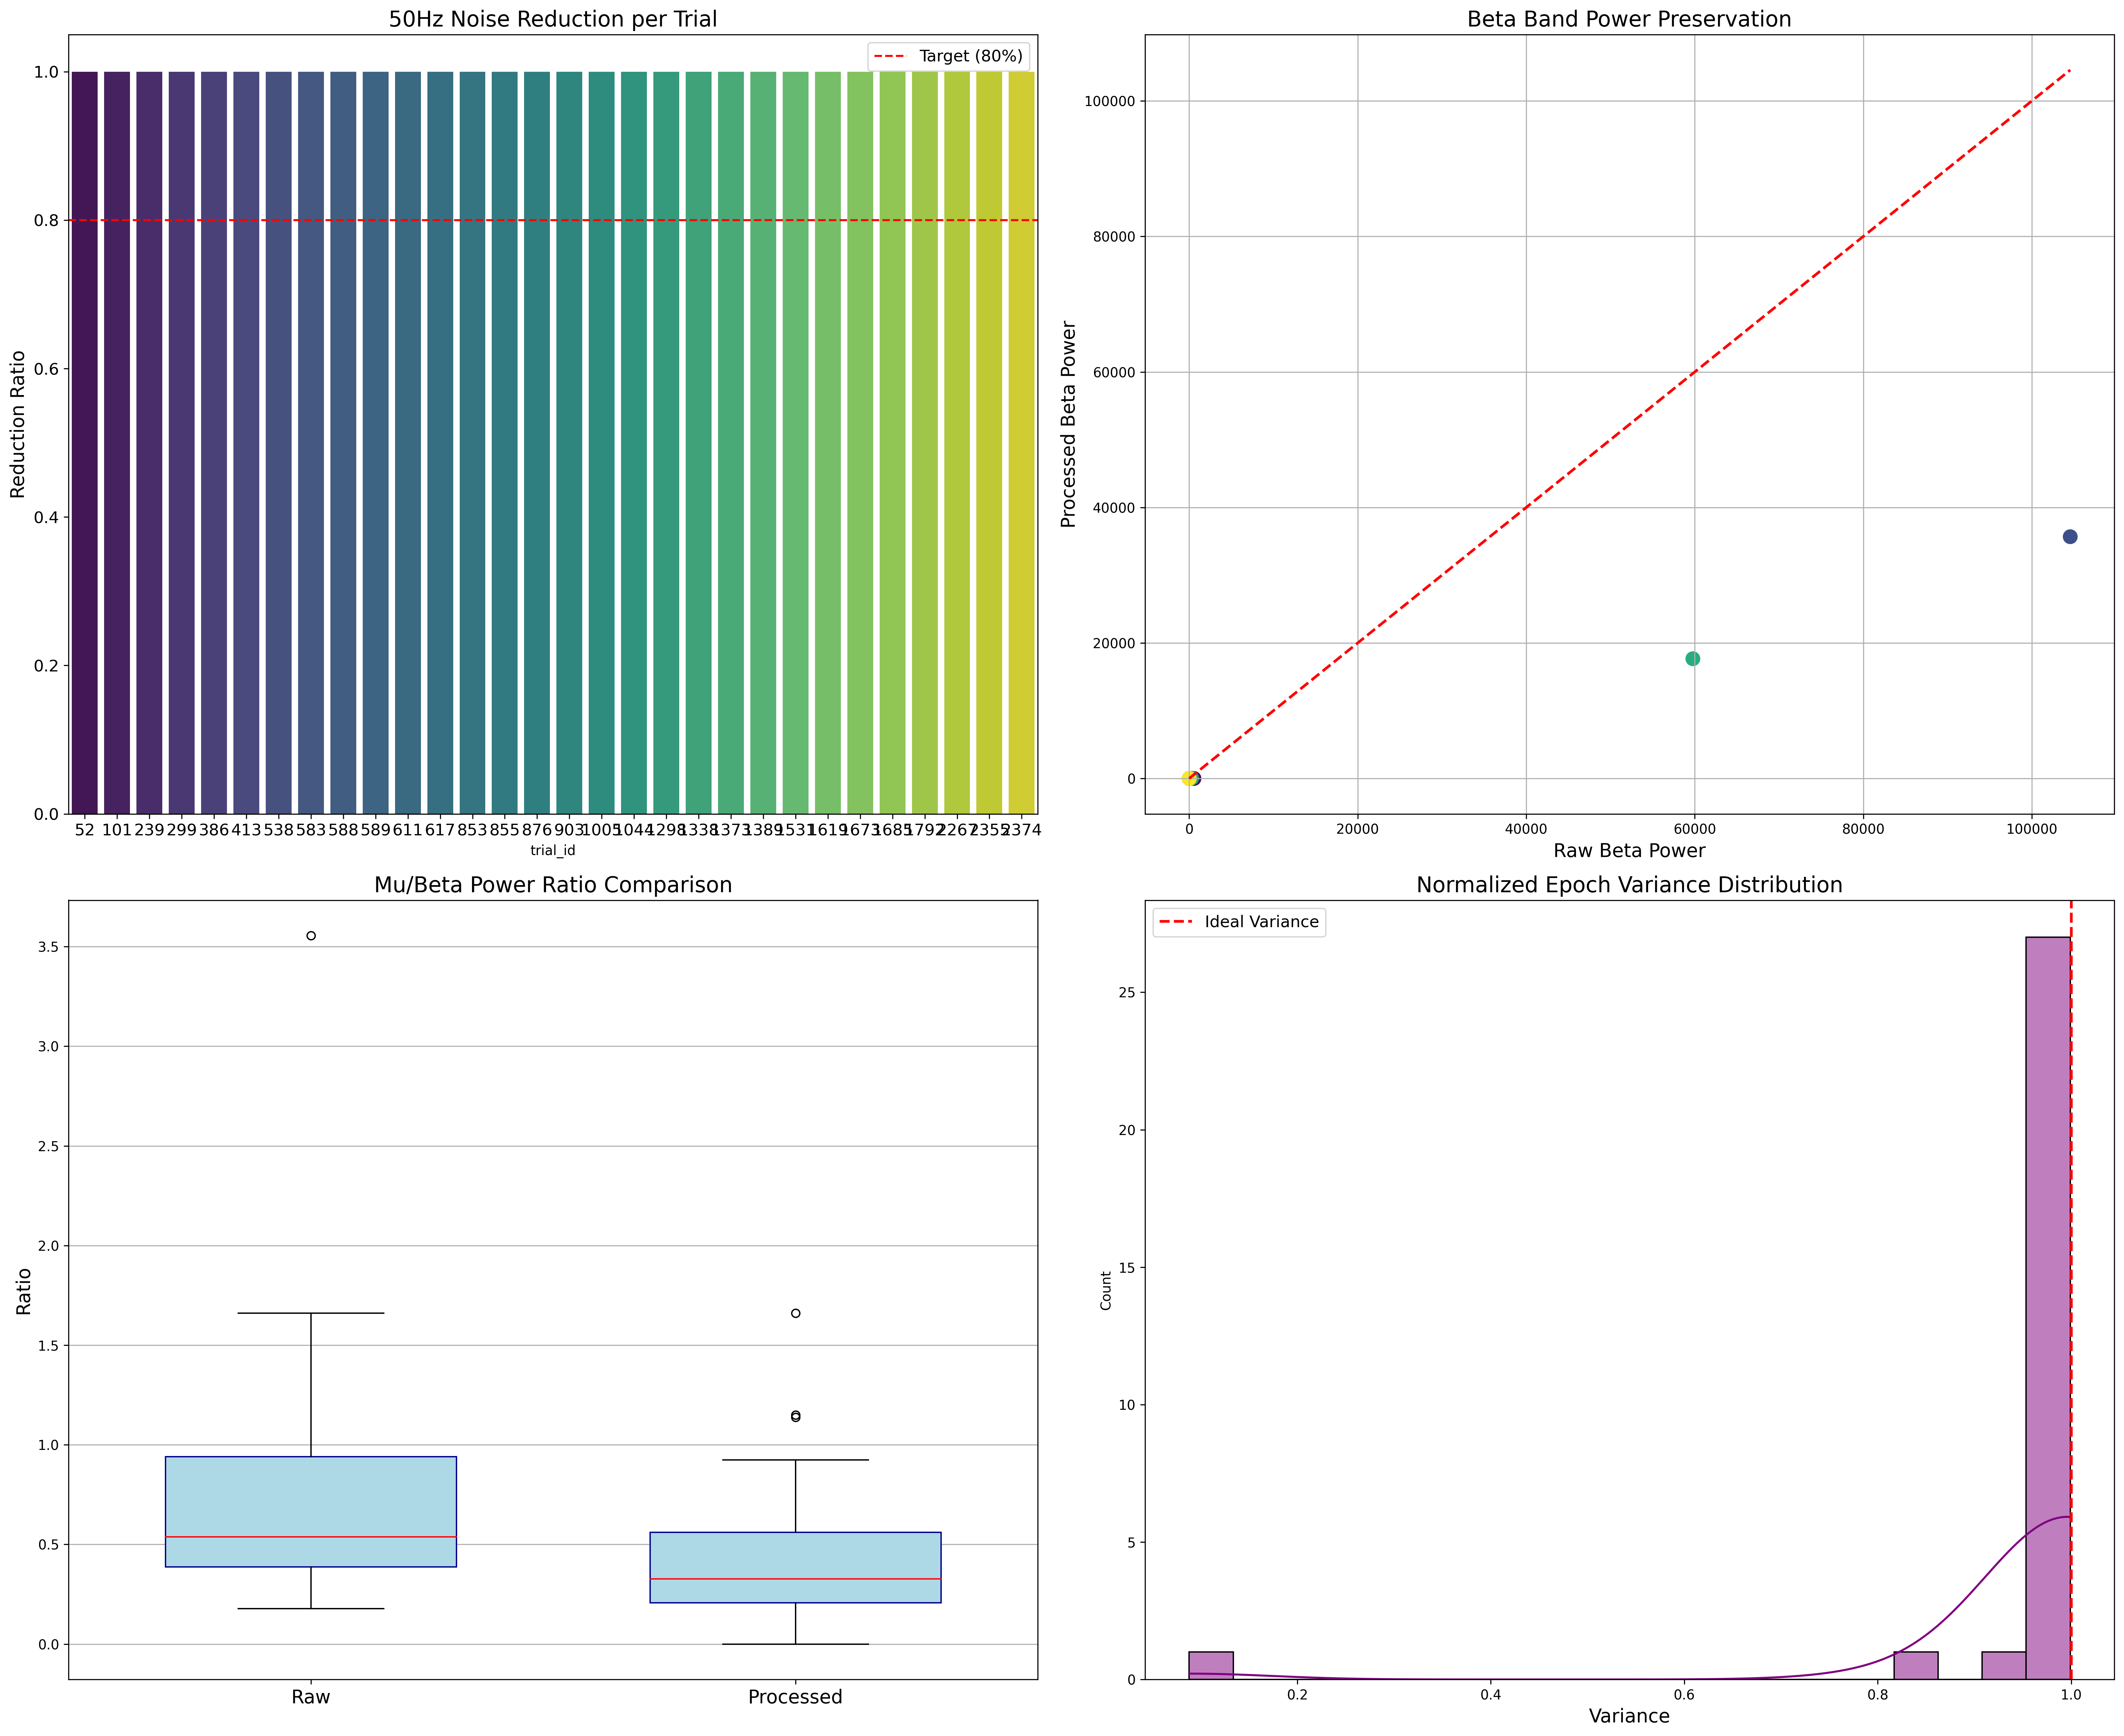


Processing complete! Check diagnostic_plots and preprocessed_data directories.


In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, iirnotch, welch, filtfilt, sosfiltfilt
from scipy.stats import kurtosis
import mne
from mne.preprocessing import ICA
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import matplotlib as mpl
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set higher DPI for better quality figures
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# --- CONSTANTS ---
BASE_PATH = '/kaggle/working/mtc-aic3-cleaned'
SAMPLING_RATE = 250
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
CHANNEL_MAPPING = {
    'FZ': 'Fz',
    'C3': 'C3',
    'CZ': 'Cz',
    'C4': 'C4',
    'PZ': 'Pz',
    'PO7': 'PO7',
    'OZ': 'Oz',
    'PO8': 'PO8'
}
MI_SAMPLES_PER_TRIAL = 2250  # 9 seconds * 250 Hz
LOW_CUT = 1.0
HIGH_CUT = 40.0
NOTCH_FREQ = 50.0
Q_FACTOR = 30.0
T_MIN, T_MAX = 3.5, 7.5  # Stimulation period for MI
ICA_THRESHOLD = 3.0
KURTOSIS_THRESHOLD = 1.5  # For automatic component rejection
NORMALIZATION_EPSILON = np.finfo(np.float64).eps * 10

# Standard EEG montage for digitization
STANDARD_MONTAGE = mne.channels.make_standard_montage('standard_1005')

# --- PREPROCESSING FUNCTIONS ---
def apply_filters(data):
    """Apply notch and bandpass filters using SOS method for stability"""
    # Design notch filter
    b_notch, a_notch = iirnotch(NOTCH_FREQ, Q_FACTOR, SAMPLING_RATE)
    
    nyquist = 0.5 * SAMPLING_RATE
    low = LOW_CUT / nyquist
    high = HIGH_CUT / nyquist
    
    # Design bandpass filter as SOS
    sos_band = butter(4, [low, high], btype='bandpass', output='sos')
    
    filtered_data = data.copy()
    for channel in EEG_CHANNELS:
        # Apply notch filter
        notched = filtfilt(b_notch, a_notch, data[channel])
        
        # Apply bandpass filter
        filtered_data[channel] = sosfiltfilt(sos_band, notched)
        
    return filtered_data

def common_average_reference(data):
    """Apply CAR to EEG channels"""
    mean_per_sample = data[EEG_CHANNELS].mean(axis=1)
    referenced_data = data.copy()
    referenced_data[EEG_CHANNELS] = data[EEG_CHANNELS].subtract(mean_per_sample, axis=0)
    return referenced_data

def apply_ica_to_session(session_data):
    """Apply ICA to an entire session (concatenated trials)"""
    # Scale to volts for MNE
    data_scaled = session_data.values.T * 1e-6
    
    # Create MNE info structure with standard montage
    info = mne.create_info(
        ch_names=EEG_CHANNELS,
        sfreq=SAMPLING_RATE,
        ch_types='eeg',
        verbose=False
    )
    
    # Create MNE Raw object
    raw = mne.io.RawArray(data_scaled, info, verbose=False)
    
    # Set montage with proper channel mapping
    raw.rename_channels(CHANNEL_MAPPING)
    raw.set_montage(STANDARD_MONTAGE)
    
    # High-pass filter for ICA (1Hz cutoff)
    raw_for_ica = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    
    # Use fixed number of components (rank of data)
    n_components = min(data_scaled.shape[0], 7)  # Max 7 components for 8-channel CAR data
    
    # Fit ICA with more robust settings
    ica = ICA(
        method='infomax',
        n_components=n_components,
        max_iter=1000,
        random_state=42,
        verbose=False
    )
    
    try:
        ica.fit(raw_for_ica)
    except RuntimeError as e:
        print(f"ICA fitting failed: {str(e)}")
        return None, None
    
    # Compute kurtosis scores
    sources = ica.get_sources(raw_for_ica).get_data()
    kurtosis_scores = kurtosis(sources, axis=1, fisher=True)
    artifact_components = np.where(np.abs(kurtosis_scores) > KURTOSIS_THRESHOLD)[0]
    ica.exclude = artifact_components.tolist()
    
    # Automatically detect EOG artifacts
    frontal_channels = ['Fz']  # Use mapped channel name
    eog_indices = []
    for ch in frontal_channels:
        try:
            idx, _ = ica.find_bads_eog(
                raw, 
                ch_name=ch, 
                threshold=ICA_THRESHOLD,
                verbose=False
            )
            if idx:
                eog_indices.extend(idx)
        except Exception as e:
            print(f"EOG detection failed: {str(e)}")
    
    # Add EOG components to exclusion
    if eog_indices:
        ica.exclude = list(set(ica.exclude + eog_indices))
    
    return ica, raw

def apply_ica_to_trial(trial_data, ica):
    """Apply precomputed ICA to a single trial"""
    # Scale to volts for MNE
    data_scaled = trial_data.values.T * 1e-6
    
    # Create MNE info structure
    info = mne.create_info(
        ch_names=EEG_CHANNELS,
        sfreq=SAMPLING_RATE,
        ch_types='eeg',
        verbose=False
    )
    
    # Create MNE Raw object
    raw = mne.io.RawArray(data_scaled, info, verbose=False)
    
    # Set montage with proper channel mapping
    raw.rename_channels(CHANNEL_MAPPING)
    raw.set_montage(STANDARD_MONTAGE)
    
    # Apply ICA cleaning
    if ica and ica.exclude:
        raw_cleaned = raw.copy()
        ica.apply(raw_cleaned, verbose=False)
        cleaned_data = raw_cleaned.get_data() * 1e6
    else:
        cleaned_data = data_scaled * 1e6
    
    return cleaned_data.T

def per_trial_standardization(epoch_df):
    """Z-score normalization with proper epsilon handling"""
    mean = epoch_df.mean(axis=0)
    std = epoch_df.std(axis=0)
    normalized_df = (epoch_df - mean) / (std + NORMALIZATION_EPSILON)
    return normalized_df

def load_session_data(subject_id, session_id, task, dataset_split):
    """Load entire session EEG data"""
    # Construct path to EEG data
    eeg_path = os.path.join(
        BASE_PATH, 
        task, 
        dataset_split, 
        subject_id, 
        str(session_id), 
        'EEGdata.csv'
    )
    
    # Load and verify data
    if not os.path.exists(eeg_path):
        raise FileNotFoundError(f"EEG data not found at: {eeg_path}")
    
    session_data = pd.read_csv(eeg_path)
    
    # Extract relevant channels
    available_channels = [col for col in EEG_CHANNELS if col in session_data.columns]
    if len(available_channels) != len(EEG_CHANNELS):
        missing = set(EEG_CHANNELS) - set(available_channels)
        print(f"Warning: Missing channels {missing} in {eeg_path}")
    
    return session_data[available_channels]

# --- PROCESSING PIPELINE ---
def preprocess_trial(trial_data, ica=None):
    """Full preprocessing pipeline for a single trial"""
    # 1. Demean the data
    demeaned = trial_data - trial_data.mean()
    
    # 2. Apply filters
    filtered = apply_filters(demeaned)
    
    # 3. Common Average Reference
    referenced = common_average_reference(filtered)
    
    # 4. ICA Cleaning (if provided)
    if ica is not None:
        cleaned = apply_ica_to_trial(referenced, ica)
        cleaned_df = pd.DataFrame(cleaned, columns=EEG_CHANNELS)
    else:
        cleaned_df = referenced.copy()
    
    # 5. Extract stimulation period (3.5-7.5s)
    start_sample = int(T_MIN * SAMPLING_RATE)
    end_sample = int(T_MAX * SAMPLING_RATE)
    epoch = cleaned_df.iloc[start_sample:end_sample].reset_index(drop=True)
    
    # 6. Standardize epoch
    normalized_epoch = per_trial_standardization(epoch)
    
    return {
        'raw': trial_data,
        'filtered': filtered,
        'referenced': referenced,
        'cleaned': cleaned_df,
        'epoch': normalized_epoch,
        'ica': ica
    }

# --- ENHANCED DIAGNOSTICS & VISUALIZATION ---
def plot_trial_diagnostics(processed_data, title):
    """Generate comprehensive diagnostics for a single trial"""
    channel = 'C3'  # Focus on motor cortex
    raw = processed_data['raw']
    filtered = processed_data['filtered']
    cleaned = processed_data['cleaned']
    epoch = processed_data['epoch']
    
    # Time vectors
    time_full = np.arange(len(raw)) / SAMPLING_RATE
    time_epoch = np.linspace(T_MIN, T_MAX, len(epoch))
    
    fig = plt.figure(figsize=(25, 30))
    fig.suptitle(f'MI Trial Diagnostics: {title}', fontsize=24, y=0.98)
    gs = GridSpec(5, 3, figure=fig)
    
    # --- Before/After Amplitude Comparison ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_full, raw[channel], label='Raw Signal', alpha=0.8, color='blue')
    ax1.plot(time_full, cleaned[channel], label='Processed Signal', alpha=0.8, color='red')
    ax1.axvspan(T_MIN, T_MAX, color='green', alpha=0.2, label='Stimulation Period')
    ax1.set_title('Before/After Processing - Full Trial', fontsize=16)
    ax1.set_xlabel('Time (s)', fontsize=14)
    ax1.set_ylabel('Amplitude (µV)', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True)
    
    # --- Stimulation Period Detail ---
    start_idx = int(T_MIN * SAMPLING_RATE)
    end_idx = int(T_MAX * SAMPLING_RATE)
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(time_epoch, raw[channel].iloc[start_idx:end_idx], 
             label='Raw', alpha=0.8, color='blue')
    ax2.plot(time_epoch, cleaned[channel].iloc[start_idx:end_idx], 
             label='Processed', alpha=0.8, color='red')
    ax2.plot(time_epoch, epoch[channel], 
             label='Normalized', alpha=1.0, color='green', linewidth=1.5)
    ax2.set_title('Stimulation Period Detail (3.5-7.5s)', fontsize=16)
    ax2.set_xlabel('Time (s)', fontsize=14)
    ax2.set_ylabel('Amplitude', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True)
    
    # --- PSD Comparison ---
    ax3 = fig.add_subplot(gs[2, 0])
    freqs, psd_raw = welch(raw[channel], SAMPLING_RATE, nperseg=SAMPLING_RATE*2)
    ax3.semilogy(freqs, psd_raw, label='Raw', color='blue')
    freqs, psd_clean = welch(cleaned[channel], SAMPLING_RATE, nperseg=SAMPLING_RATE*2)
    ax3.semilogy(freqs, psd_clean, label='Processed', color='red')
    ax3.set_title('Full Trial PSD Comparison', fontsize=16)
    ax3.set_xlabel('Frequency (Hz)', fontsize=14)
    ax3.set_ylabel('Power (µV²/Hz)', fontsize=14)
    ax3.legend(fontsize=12)
    ax3.grid(True)
    ax3.set_xlim(1, 60)
    
    # --- Mu/Beta Band Focus ---
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.plot(freqs, psd_raw, label='Raw', color='blue', alpha=0.7)
    ax4.plot(freqs, psd_clean, label='Processed', color='red')
    ax4.set_title('Mu/Beta Bands (8-30 Hz)', fontsize=16)
    ax4.set_xlabel('Frequency (Hz)', fontsize=14)
    ax4.set_ylabel('Power (µV²/Hz)', fontsize=14)
    ax4.legend(fontsize=12)
    ax4.grid(True)
    ax4.set_xlim(8, 30)
    
    # --- Normalized Epoch PSD ---
    ax5 = fig.add_subplot(gs[2, 2])
    freqs, psd_norm = welch(epoch[channel], SAMPLING_RATE, nperseg=SAMPLING_RATE*2)
    ax5.semilogy(freqs, psd_norm, color='green')
    ax5.set_title('Normalized Epoch PSD', fontsize=16)
    ax5.set_xlabel('Frequency (Hz)', fontsize=14)
    ax5.set_ylabel('Power', fontsize=14)
    ax5.grid(True)
    ax5.set_xlim(1, 60)
    
    # --- Amplitude Distribution Comparison ---
    ax6 = fig.add_subplot(gs[3, 0])
    sns.histplot(raw[channel], bins=50, label='Raw', alpha=0.5, color='blue', ax=ax6)
    sns.histplot(cleaned[channel], bins=50, label='Processed', alpha=0.5, color='red', ax=ax6)
    ax6.set_title('Amplitude Distribution - Full Trial', fontsize=16)
    ax6.set_xlabel('Amplitude (µV)', fontsize=14)
    ax6.legend(fontsize=12)
    
    # --- Epoch Distribution Comparison ---
    ax7 = fig.add_subplot(gs[3, 1])
    sns.histplot(raw[channel].iloc[start_idx:end_idx], 
                bins=50, label='Raw', alpha=0.5, color='blue', ax=ax7)
    sns.histplot(cleaned[channel].iloc[start_idx:end_idx], 
                bins=50, label='Processed', alpha=0.5, color='red', ax=ax7)
    ax7.set_title('Amplitude Distribution - Stimulation Period', fontsize=16)
    ax7.set_xlabel('Amplitude (µV)', fontsize=14)
    ax7.legend(fontsize=12)
    
    # --- Normalized Distribution ---
    ax8 = fig.add_subplot(gs[3, 2])
    sns.histplot(epoch[channel], bins=50, color='green')
    ax8.axvline(0, color='r', linestyle='--')
    ax8.axvline(1, color='g', linestyle='--', alpha=0.5)
    ax8.axvline(-1, color='g', linestyle='--', alpha=0.5)
    ax8.set_title('Normalized Epoch Distribution', fontsize=16)
    ax8.set_xlabel('Z-score', fontsize=14)
    
    # --- Time-Frequency Analysis ---
    ax9 = fig.add_subplot(gs[4, :])
    # Create a PSD array for visualization
    freq_bins = np.linspace(1, 40, 40)
    time_bins = np.linspace(0, 9, 20)
    psd_map = np.zeros((len(freq_bins)-1, len(time_bins)-1))
    
    # Calculate PSD in time windows
    for i in range(len(time_bins)-1):
        start = int(time_bins[i] * SAMPLING_RATE)
        end = int(time_bins[i+1] * SAMPLING_RATE)
        segment = cleaned[channel].iloc[start:end]
        if len(segment) > 10:  # Ensure we have enough samples
            freqs, psd = welch(segment, SAMPLING_RATE, nperseg=min(256, len(segment)))
            for j in range(len(freq_bins)-1):
                idx = np.logical_and(freqs >= freq_bins[j], freqs < freq_bins[j+1])
                if np.any(idx):
                    psd_map[j, i] = np.mean(psd[idx])
    
    # Plot time-frequency map
    if np.any(psd_map > 0):  # Only plot if we have data
        c = ax9.pcolormesh(time_bins, freq_bins, psd_map, shading='auto', cmap='viridis')
        ax9.set_title('Time-Frequency Power Map (Processed Signal)', fontsize=16)
        ax9.set_xlabel('Time (s)', fontsize=14)
        ax9.set_ylabel('Frequency (Hz)', fontsize=14)
        fig.colorbar(c, ax=ax9, label='Power (µV²/Hz)')
        ax9.axvspan(T_MIN, T_MAX, color='red', alpha=0.2)
    else:
        ax9.text(0.5, 0.5, 'Insufficient data for time-frequency analysis', 
                ha='center', va='center', fontsize=16)
        ax9.set_title('Time-Frequency Analysis Not Available', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'diagnostic_plots/{title.replace(" ", "_")}.png', bbox_inches='tight')
    plt.close()
    
    return fig

# --- DATA QUALITY METRICS ---
def calculate_band_power(signal, fs=SAMPLING_RATE):
    """Calculate band power in MI-relevant frequency bands"""
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'mu': (8, 13),
        'beta_low': (13, 20),
        'beta_high': (20, 30),
        'gamma': (30, 40),
        'notch': (49, 51)
    }
    band_power = {}
    for name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        if np.any(idx):
            band_power[name] = np.trapz(psd[idx], freqs[idx])
        else:
            band_power[name] = 0.0
    
    band_power['beta'] = band_power['beta_low'] + band_power['beta_high']
    band_power['mu_beta_ratio'] = band_power['beta'] / (band_power['mu'] + 1e-10)
    
    # Calculate SNR as (signal power) / (noise power)
    signal_power = band_power['mu'] + band_power['beta']
    noise_power = (band_power['notch'] + band_power['delta'] + band_power['theta'] + band_power['gamma'])
    band_power['snr'] = signal_power / (noise_power + 1e-10)
    
    return band_power

def calculate_signal_metrics(processed_data):
    """Calculate signal quality metrics at each processing stage"""
    channel = 'C3'
    metrics = {}
    
    # Raw signal metrics
    raw_signal = processed_data['raw'][channel].values
    raw_metrics = calculate_band_power(raw_signal)
    metrics['raw_notch'] = raw_metrics['notch']
    metrics['raw_snr'] = raw_metrics['snr']
    metrics['raw_beta'] = raw_metrics['beta']
    metrics['raw_mu_beta_ratio'] = raw_metrics['mu_beta_ratio']
    
    # Filtered signal metrics
    filt_signal = processed_data['filtered'][channel].values
    filt_metrics = calculate_band_power(filt_signal)
    metrics['filt_notch'] = filt_metrics['notch']
    metrics['filt_snr'] = filt_metrics['snr']
    metrics['filt_beta'] = filt_metrics['beta']
    metrics['filt_mu_beta_ratio'] = filt_metrics['mu_beta_ratio']
    
    # ICA cleaned signal metrics
    clean_signal = processed_data['cleaned'][channel].values
    clean_metrics = calculate_band_power(clean_signal)
    metrics['clean_notch'] = clean_metrics['notch']
    metrics['clean_snr'] = clean_metrics['snr']
    metrics['clean_beta'] = clean_metrics['beta']
    metrics['clean_mu_beta_ratio'] = clean_metrics['mu_beta_ratio']
    
    # Epoch metrics
    epoch_signal = processed_data['epoch'][channel].values
    epoch_metrics = calculate_band_power(epoch_signal)
    metrics['epoch_notch'] = epoch_metrics['notch']
    metrics['epoch_snr'] = epoch_metrics['snr']
    metrics['epoch_beta'] = epoch_metrics['beta']
    metrics['epoch_mu_beta_ratio'] = epoch_metrics['mu_beta_ratio']
    
    # Additional metrics
    metrics['variance_epoch'] = np.var(epoch_signal)
    metrics['max_amp_raw'] = np.max(np.abs(raw_signal))
    
    return metrics

# --- MAIN EXECUTION ---
def main():
    # Create output directory
    os.makedirs('diagnostic_plots', exist_ok=True)
    os.makedirs('preprocessed_data', exist_ok=True)
    
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_train_df = train_df[train_df['task'] == 'MI']
    
    # Group by session for ICA
    session_groups = mi_train_df.groupby(['subject_id', 'trial_session'])
    session_icas = {}
    
    # For demo: only process first 5 sessions to save time
    demo_sessions = list(session_groups)[:28]
    
    print("Computing ICA for sessions...")
    for (subject_id, session_id), group_df in tqdm(demo_sessions, total=len(demo_sessions)):
        try:
            # Load entire session data
            session_data = load_session_data(subject_id, session_id, 'MI', 'train')
            
            # Preprocess session data (without ICA)
            demeaned = session_data - session_data.mean()
            filtered = apply_filters(demeaned)
            referenced = common_average_reference(filtered)
            
            # Compute ICA for session
            ica, _ = apply_ica_to_session(referenced)
            session_icas[(subject_id, session_id)] = ica
        except Exception as e:
            print(f"Error processing session {subject_id}-{session_id}: {str(e)}")
            session_icas[(subject_id, session_id)] = None
    
    # Process 5 random trials for detailed diagnostics
    all_trials = mi_train_df.sample(30, random_state=42)
    all_metrics = []
    
    print("\nProcessing demo trials for diagnostics...")
    for idx, row in tqdm(all_trials.iterrows(), total=len(all_trials)):
        try:
            # Load session data
            session_data = load_session_data(
                row['subject_id'], 
                row['trial_session'], 
                'MI', 
                'train'
            )
            
            # Extract trial from session
            start_idx = (row['trial'] - 1) * MI_SAMPLES_PER_TRIAL
            end_idx = start_idx + MI_SAMPLES_PER_TRIAL
            trial_data = session_data.iloc[start_idx:end_idx].copy()
            
            # Get ICA for this session
            ica = session_icas.get((row['subject_id'], row['trial_session']))
            
            # Preprocess trial using session's ICA
            processed = preprocess_trial(trial_data, ica=ica)
            
            # Generate diagnostics
            title = f"Sub_{row['subject_id']}_Trial_{row['trial']}_Label_{row['label']}"
            plot_trial_diagnostics(processed, title)
            
            # Calculate metrics
            metrics = calculate_signal_metrics(processed)
            metrics.update({
                'subject_id': row['subject_id'],
                'trial_id': row['id'],
                'label': row['label']
            })
            all_metrics.append(metrics)
            
            # Save preprocessed epoch data
            epoch_data = processed['epoch']
            np.save(f"preprocessed_data/{title}.npy", epoch_data.values)
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
    
    # --- Generate Quality Report ---
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        
        # Calculate improvements
        metrics_df['notch_reduction'] = 1 - (metrics_df['filt_notch'] / metrics_df['raw_notch'])
        metrics_df['snr_improvement'] = (metrics_df['filt_snr'] / metrics_df['raw_snr']) - 1
        metrics_df['beta_preservation'] = metrics_df['clean_beta'] / metrics_df['raw_beta']
        metrics_df['mu_beta_ratio_change'] = metrics_df['clean_mu_beta_ratio'] / metrics_df['raw_mu_beta_ratio'] - 1
        
        print("\n=== SIGNAL QUALITY REPORT ===")
        print(f"Average 50Hz Reduction: {metrics_df['notch_reduction'].mean()*100:.1f}%")
        print(f"Average SNR Improvement: {metrics_df['snr_improvement'].mean()*100:.1f}%")
        print(f"Average Beta Preservation: {metrics_df['beta_preservation'].mean()*100:.1f}%")
        print(f"Average Mu/Beta Ratio Change: {metrics_df['mu_beta_ratio_change'].mean()*100:.1f}%")
        print(f"Normalized Epoch Variance: {metrics_df['variance_epoch'].mean():.2f} ± {metrics_df['variance_epoch'].std():.2f}")
        
        # Save metrics
        metrics_df.to_csv('signal_quality_metrics.csv', index=False)
        
        # --- Generate Summary Plots ---
        plt.figure(figsize=(22, 18))
        
        # Notch Reduction
        plt.subplot(2, 2, 1)
        sns.barplot(x='trial_id', y='notch_reduction', data=metrics_df, palette='viridis')
        plt.title('50Hz Noise Reduction per Trial', fontsize=16)
        plt.ylabel('Reduction Ratio', fontsize=14)
        plt.axhline(0.8, color='r', linestyle='--', label='Target (80%)')
        plt.legend(fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Beta Preservation
        plt.subplot(2, 2, 2)
        plt.scatter(metrics_df['raw_beta'], metrics_df['clean_beta'], 
                   c=metrics_df.index, cmap='viridis', s=100)
        plt.plot([0, metrics_df['raw_beta'].max()], [0, metrics_df['raw_beta'].max()], 'r--', linewidth=2)
        plt.title('Beta Band Power Preservation', fontsize=16)
        plt.xlabel('Raw Beta Power', fontsize=14)
        plt.ylabel('Processed Beta Power', fontsize=14)
        plt.grid(True)
        
        # Mu/Beta Ratio
        plt.subplot(2, 2, 3)
        plt.boxplot([metrics_df['raw_mu_beta_ratio'], metrics_df['clean_mu_beta_ratio']], 
                   widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='darkblue'),
                   medianprops=dict(color='red'))
        plt.xticks([1, 2], ['Raw', 'Processed'], fontsize=14)
        plt.title('Mu/Beta Power Ratio Comparison', fontsize=16)
        plt.ylabel('Ratio', fontsize=14)
        plt.grid(True, axis='y')
        
        # Variance Distribution
        plt.subplot(2, 2, 4)
        sns.histplot(metrics_df['variance_epoch'], bins=20, kde=True, color='purple')
        plt.axvline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal Variance')
        plt.title('Normalized Epoch Variance Distribution', fontsize=16)
        plt.xlabel('Variance', fontsize=14)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig('quality_summary.png', bbox_inches='tight')
        plt.show()
    else:
        print("No metrics collected due to processing errors")
    
    print("\nProcessing complete! Check diagnostic_plots and preprocessed_data directories.")

if __name__ == '__main__':
    main()

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, iirnotch, welch, filtfilt, sosfiltfilt
from scipy.stats import kurtosis
import mne
from mne.preprocessing import ICA
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

BASE_PATH = '/kaggle/working/mtc-aic3-cleaned'
SAMPLING_RATE = 250
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
CHANNEL_MAPPING = {
    'FZ': 'Fz',
    'C3': 'C3',
    'CZ': 'Cz',
    'C4': 'C4',
    'PZ': 'Pz',
    'PO7': 'PO7',
    'OZ': 'Oz',
    'PO8': 'PO8'
}
MI_SAMPLES_PER_TRIAL = 2250
LOW_CUT = 1.0
HIGH_CUT = 40.0
NOTCH_FREQ = 50.0
Q_FACTOR = 30.0
T_MIN, T_MAX = 3.5, 7.5
ICA_THRESHOLD = 3.0
KURTOSIS_THRESHOLD = 1.5
NORMALIZATION_EPSILON = np.finfo(np.float64).eps * 10

STANDARD_MONTAGE = mne.channels.make_standard_montage('standard_1005')

# --- PREPROCESSING FUNCTIONS ---
def apply_filters(data):
    """Apply notch and bandpass filters using SOS method for stability"""
    b_notch, a_notch = iirnotch(NOTCH_FREQ, Q_FACTOR, SAMPLING_RATE)
    
    nyquist = 0.5 * SAMPLING_RATE
    low = LOW_CUT / nyquist
    high = HIGH_CUT / nyquist
    
    sos_band = butter(4, [low, high], btype='bandpass', output='sos')
    
    filtered_data = data.copy()
    for channel in EEG_CHANNELS:
        notched = filtfilt(b_notch, a_notch, data[channel])
        
        filtered_data[channel] = sosfiltfilt(sos_band, notched)
        
    return filtered_data

def common_average_reference(data):
    """Apply CAR to EEG channels"""
    mean_per_sample = data[EEG_CHANNELS].mean(axis=1)
    referenced_data = data.copy()
    referenced_data[EEG_CHANNELS] = data[EEG_CHANNELS].subtract(mean_per_sample, axis=0)
    return referenced_data

def apply_ica_to_session(session_data):
    """Apply ICA to an entire session (concatenated trials)"""
    data_scaled = session_data.values.T * 1e-6
    
    info = mne.create_info(
        ch_names=EEG_CHANNELS,
        sfreq=SAMPLING_RATE,
        ch_types='eeg',
        verbose=False
    )
    
    raw = mne.io.RawArray(data_scaled, info, verbose=False)
    
    raw.rename_channels(CHANNEL_MAPPING)
    raw.set_montage(STANDARD_MONTAGE)
    
    raw_for_ica = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    
    n_components = min(data_scaled.shape[0], 7)
    
    ica = ICA(
        method='infomax',
        n_components=n_components,
        max_iter=1000,
        random_state=42,
        verbose=False
    )
    
    try:
        ica.fit(raw_for_ica)
    except RuntimeError as e:
        print(f"ICA fitting failed: {str(e)}")
        return None, None
    
    sources = ica.get_sources(raw_for_ica).get_data()
    kurtosis_scores = kurtosis(sources, axis=1, fisher=True)
    artifact_components = np.where(np.abs(kurtosis_scores) > KURTOSIS_THRESHOLD)[0]
    ica.exclude = artifact_components.tolist()
    
    frontal_channels = ['Fz']
    eog_indices = []
    for ch in frontal_channels:
        try:
            idx, _ = ica.find_bads_eog(
                raw, 
                ch_name=ch, 
                threshold=ICA_THRESHOLD,
                verbose=False
            )
            if idx:
                eog_indices.extend(idx)
        except Exception as e:
            print(f"EOG detection failed: {str(e)}")
    
    if eog_indices:
        ica.exclude = list(set(ica.exclude + eog_indices))
    
    return ica, raw

def apply_ica_to_trial(trial_data, ica):
    """Apply precomputed ICA to a single trial"""
    data_scaled = trial_data.values.T * 1e-6
    
    info = mne.create_info(
        ch_names=EEG_CHANNELS,
        sfreq=SAMPLING_RATE,
        ch_types='eeg',
        verbose=False
    )
    
    raw = mne.io.RawArray(data_scaled, info, verbose=False)
    
    raw.rename_channels(CHANNEL_MAPPING)
    raw.set_montage(STANDARD_MONTAGE)
    
    if ica and ica.exclude:
        raw_cleaned = raw.copy()
        ica.apply(raw_cleaned, verbose=False)
        cleaned_data = raw_cleaned.get_data() * 1e6
    else:
        cleaned_data = data_scaled * 1e6
    
    return cleaned_data.T

def per_trial_standardization(epoch_df):
    """Z-score normalization with proper epsilon handling"""
    mean = epoch_df.mean(axis=0)
    std = epoch_df.std(axis=0)
    normalized_df = (epoch_df - mean) / (std + NORMALIZATION_EPSILON)
    return normalized_df

def load_session_data(subject_id, session_id, task, dataset_split):
    """Load entire session EEG data"""
    eeg_path = os.path.join(
        BASE_PATH, 
        task, 
        dataset_split, 
        subject_id, 
        str(session_id), 
        'EEGdata.csv'
    )
    
    if not os.path.exists(eeg_path):
        raise FileNotFoundError(f"EEG data not found at: {eeg_path}")
    
    session_data = pd.read_csv(eeg_path)
    
    available_channels = [col for col in EEG_CHANNELS if col in session_data.columns]
    if len(available_channels) != len(EEG_CHANNELS):
        missing = set(EEG_CHANNELS) - set(available_channels)
        print(f"Warning: Missing channels {missing} in {eeg_path}")
    
    return session_data[available_channels]

# --- PROCESSING PIPELINE ---
def preprocess_trial(trial_data, ica=None):
    """Full preprocessing pipeline for a single trial"""
    demeaned = trial_data - trial_data.mean()
    
    filtered = apply_filters(demeaned)
    
    referenced = common_average_reference(filtered)
    
    if ica is not None:
        cleaned = apply_ica_to_trial(referenced, ica)
        cleaned_df = pd.DataFrame(cleaned, columns=EEG_CHANNELS)
    else:
        cleaned_df = referenced.copy()
    
    start_sample = int(T_MIN * SAMPLING_RATE)
    end_sample = int(T_MAX * SAMPLING_RATE)
    epoch = cleaned_df.iloc[start_sample:end_sample].reset_index(drop=True)
    
    normalized_epoch = per_trial_standardization(epoch)
    
    return {
        'raw': trial_data,
        'filtered': filtered,
        'referenced': referenced,
        'cleaned': cleaned_df,
        'epoch': normalized_epoch,
        'ica': ica
    }



def calculate_band_power(signal, fs=SAMPLING_RATE):
    """Calculate band power in MI-relevant frequency bands"""
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'mu': (8, 13),
        'beta_low': (13, 20),
        'beta_high': (20, 30),
        'gamma': (30, 40),
        'notch': (49, 51)
    }
    band_power = {}
    for name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        if np.any(idx):
            band_power[name] = np.trapz(psd[idx], freqs[idx])
        else:
            band_power[name] = 0.0
    
    band_power['beta'] = band_power['beta_low'] + band_power['beta_high']
    band_power['mu_beta_ratio'] = band_power['beta'] / (band_power['mu'] + 1e-10)
    
    signal_power = band_power['mu'] + band_power['beta']
    noise_power = (band_power['notch'] + band_power['delta'] + band_power['theta'] + band_power['gamma'])
    band_power['snr'] = signal_power / (noise_power + 1e-10)
    
    return band_power

def calculate_signal_metrics(processed_data):
    """Calculate signal quality metrics at each processing stage"""
    channel = 'C3'
    metrics = {}
    
    raw_signal = processed_data['raw'][channel].values
    raw_metrics = calculate_band_power(raw_signal)
    metrics['raw_notch'] = raw_metrics['notch']
    metrics['raw_snr'] = raw_metrics['snr']
    metrics['raw_beta'] = raw_metrics['beta']
    metrics['raw_mu_beta_ratio'] = raw_metrics['mu_beta_ratio']
    
    filt_signal = processed_data['filtered'][channel].values
    filt_metrics = calculate_band_power(filt_signal)
    metrics['filt_notch'] = filt_metrics['notch']
    metrics['filt_snr'] = filt_metrics['snr']
    metrics['filt_beta'] = filt_metrics['beta']
    metrics['filt_mu_beta_ratio'] = filt_metrics['mu_beta_ratio']
    
    clean_signal = processed_data['cleaned'][channel].values
    clean_metrics = calculate_band_power(clean_signal)
    metrics['clean_notch'] = clean_metrics['notch']
    metrics['clean_snr'] = clean_metrics['snr']
    metrics['clean_beta'] = clean_metrics['beta']
    metrics['clean_mu_beta_ratio'] = clean_metrics['mu_beta_ratio']
    
    epoch_signal = processed_data['epoch'][channel].values
    epoch_metrics = calculate_band_power(epoch_signal)
    metrics['epoch_notch'] = epoch_metrics['notch']
    metrics['epoch_snr'] = epoch_metrics['snr']
    metrics['epoch_beta'] = epoch_metrics['beta']
    metrics['epoch_mu_beta_ratio'] = epoch_metrics['mu_beta_ratio']
    
    metrics['variance_epoch'] = np.var(epoch_signal)
    metrics['max_amp_raw'] = np.max(np.abs(raw_signal))
    
    return metrics

def main():
    os.makedirs('diagnostic_plots', exist_ok=True)
    os.makedirs('preprocessed_data', exist_ok=True)
    
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_train_df = train_df[train_df['task'] == 'MI']
    
    session_groups = mi_train_df.groupby(['subject_id', 'trial_session'])
    session_icas = {}
    
    demo_sessions = list(session_groups)[:28]
    
    print("Computing ICA for sessions...")
    for (subject_id, session_id), group_df in tqdm(demo_sessions, total=len(demo_sessions)):
        try:
            session_data = load_session_data(subject_id, session_id, 'MI', 'train')
            
            demeaned = session_data - session_data.mean()
            filtered = apply_filters(demeaned)
            referenced = common_average_reference(filtered)
            
            ica, _ = apply_ica_to_session(referenced)
            session_icas[(subject_id, session_id)] = ica
        except Exception as e:
            print(f"Error processing session {subject_id}-{session_id}: {str(e)}")
            session_icas[(subject_id, session_id)] = None
    
    all_trials = mi_train_df.sample(30, random_state=42)
    all_metrics = []
    
    print("\nProcessing demo trials for diagnostics...")
    for idx, row in tqdm(all_trials.iterrows(), total=len(all_trials)):
        try:
            # Load session data
            session_data = load_session_data(
                row['subject_id'], 
                row['trial_session'], 
                'MI', 
                'train'
            )
            
            start_idx = (row['trial'] - 1) * MI_SAMPLES_PER_TRIAL
            end_idx = start_idx + MI_SAMPLES_PER_TRIAL
            trial_data = session_data.iloc[start_idx:end_idx].copy()
            
            ica = session_icas.get((row['subject_id'], row['trial_session']))
            
            processed = preprocess_trial(trial_data, ica=ica)
            
            title = f"Sub_{row['subject_id']}_Trial_{row['trial']}_Label_{row['label']}"
            
            metrics = calculate_signal_metrics(processed)
            metrics.update({
                'subject_id': row['subject_id'],
                'trial_id': row['id'],
                'label': row['label']
            })
            all_metrics.append(metrics)
            
            epoch_data = processed['epoch']
            np.save(f"preprocessed_data/{title}.npy", epoch_data.values)
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
if __name__ == '__main__':
    main()

Computing ICA for sessions...


  0%|          | 0/28 [00:00<?, ?it/s]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


  4%|▎         | 1/28 [00:03<01:21,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


  7%|▋         | 2/28 [00:06<01:22,  3.17s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 11%|█         | 3/28 [00:09<01:18,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 14%|█▍        | 4/28 [00:12<01:13,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 18%|█▊        | 5/28 [00:15<01:11,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 21%|██▏       | 6/28 [00:18<01:09,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 25%|██▌       | 7/28 [00:21<01:06,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 29%|██▊       | 8/28 [00:25<01:03,  3.17s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 32%|███▏      | 9/28 [00:28<01:01,  3.23s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.3s.


 36%|███▌      | 10/28 [00:32<01:00,  3.34s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 39%|███▉      | 11/28 [00:35<00:54,  3.20s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 43%|████▎     | 12/28 [00:37<00:49,  3.07s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 46%|████▋     | 13/28 [00:40<00:45,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 50%|█████     | 14/28 [00:43<00:41,  2.93s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 54%|█████▎    | 15/28 [00:46<00:38,  2.96s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 57%|█████▋    | 16/28 [00:49<00:35,  2.94s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 61%|██████    | 17/28 [00:52<00:31,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 64%|██████▍   | 18/28 [00:55<00:30,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 68%|██████▊   | 19/28 [00:58<00:27,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 71%|███████▏  | 20/28 [01:01<00:24,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.2s.


 75%|███████▌  | 21/28 [01:04<00:22,  3.16s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 79%|███████▊  | 22/28 [01:08<00:18,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 82%|████████▏ | 23/28 [01:11<00:15,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 86%|████████▌ | 24/28 [01:14<00:12,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 89%|████████▉ | 25/28 [01:16<00:08,  2.93s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 93%|█████████▎| 26/28 [01:19<00:05,  2.85s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 96%|█████████▋| 27/28 [01:22<00:02,  2.88s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


100%|██████████| 28/28 [01:25<00:00,  3.05s/it]



Processing demo trials for diagnostics...


100%|██████████| 30/30 [00:03<00:00,  7.83it/s]


In [18]:
# Add these imports at the top
import shutil
from pathlib import Path

# Configuration for the new preprocessed dataset
BASE_PATH_ORIGINAL = '/kaggle/working/mtc-aic3-cleaned'  # Original dataset
BASE_PATH_PREPROCESSED = '/kaggle/working/mtc-aic3-preprocessed'  # New preprocessed dataset
USE_ICA = True  # Set to False to skip ICA processing

def preprocess_and_save_dataset():
    """Preprocess entire dataset and save in new directory structure"""
    # Create new dataset directory
    Path(BASE_PATH_PREPROCESSED).mkdir(parents=True, exist_ok=True)
    
    # Copy all CSV index files
    for csv_file in ['train.csv', 'validation.csv', 'test.csv', 'sample_submission.csv']:
        src = os.path.join(BASE_PATH_ORIGINAL, csv_file)
        dest = os.path.join(BASE_PATH_PREPROCESSED, csv_file)
        shutil.copy2(src, dest)
    
    # Process each split
    for split in ['train', 'validation', 'test']:
        print(f"\nProcessing {split} set...")
        split_df = pd.read_csv(os.path.join(BASE_PATH_ORIGINAL, f'{split}.csv'))
        mi_df = split_df[split_df['task'] == 'MI']
        
        # Get unique sessions
        session_groups = mi_df.groupby(['subject_id', 'trial_session'])
        session_icas = {}
        
        # Precompute ICA for each session
        if USE_ICA:
            print("Computing ICA for sessions...")
            for (subject_id, session_id), group_df in tqdm(session_groups, total=len(session_groups)):
                try:
                    session_data = load_session_data(subject_id, session_id, 'MI', split)
                    demeaned = session_data - session_data.mean()
                    filtered = apply_filters(demeaned)
                    referenced = common_average_reference(filtered)
                    
                    ica, _ = apply_ica_to_session(referenced)
                    session_icas[(subject_id, session_id)] = ica
                except Exception as e:
                    print(f"Error processing session {subject_id}-{session_id}: {str(e)}")
                    session_icas[(subject_id, session_id)] = None
        
        # Process each trial
        print(f"Preprocessing trials for {split}...")
        for idx, row in tqdm(mi_df.iterrows(), total=len(mi_df)):
            try:
                session_data = load_session_data(
                    row['subject_id'], 
                    row['trial_session'], 
                    'MI', 
                    split
                )
                
                start_idx = (row['trial'] - 1) * MI_SAMPLES_PER_TRIAL
                end_idx = start_idx + MI_SAMPLES_PER_TRIAL
                trial_data = session_data.iloc[start_idx:end_idx].copy()
                
                ica = session_icas.get((row['subject_id'], row['trial_session'])) if USE_ICA else None
                
                processed = preprocess_trial(trial_data, ica=ica)
                epoch_data = processed['epoch']
                
                # Save preprocessed trial
                save_path = get_preprocessed_path(row, split)
                Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)
                np.save(save_path, epoch_data.values)
                
            except Exception as e:
                print(f"Error processing trial {row['id']}: {str(e)}")
        
        # Copy SSVEP data unchanged
        ssvep_df = split_df[split_df['task'] == 'SSVEP']
        print(f"Copying SSVEP data for {split}...")
        for idx, row in tqdm(ssvep_df.iterrows(), total=len(ssvep_df)):
            try:
                src_path = get_original_path(row, split)
                dest_path = get_preprocessed_path(row, split).replace('.npy', '.csv')
                
                Path(os.path.dirname(dest_path)).mkdir(parents=True, exist_ok=True)
                shutil.copy2(src_path, dest_path)
            except Exception as e:
                print(f"Error copying SSVEP trial {row['id']}: {str(e)}")

def get_original_path(row, split):
    """Get original data path for a trial"""
    return os.path.join(
        BASE_PATH_ORIGINAL, 
        row['task'], 
        split, 
        row['subject_id'], 
        str(row['trial_session']), 
        'EEGdata.csv'
    )

def get_preprocessed_path(row, split):
    """Get preprocessed data path for a trial"""
    return os.path.join(
        BASE_PATH_PREPROCESSED, 
        row['task'], 
        split, 
        row['subject_id'], 
        str(row['trial_session']), 
        f"trial_{row['trial']}.npy"
    )

# Update your main function
def main():
    # Remove diagnostic plotting code if not needed
    preprocess_and_save_dataset()
    print("Preprocessing completed successfully!")

if __name__ == '__main__':
    main()


Processing train set...
Computing ICA for sessions...


  0%|          | 0/215 [00:00<?, ?it/s]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


  0%|          | 1/215 [00:03<11:02,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


  1%|          | 2/215 [00:06<11:23,  3.21s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


  1%|▏         | 3/215 [00:09<11:20,  3.21s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


  2%|▏         | 4/215 [00:12<11:05,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


  2%|▏         | 5/215 [00:15<10:59,  3.14s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


  3%|▎         | 6/215 [00:18<11:01,  3.16s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


  3%|▎         | 7/215 [00:22<10:50,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


  4%|▎         | 8/215 [00:25<10:49,  3.14s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


  4%|▍         | 9/215 [00:28<10:27,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


  5%|▍         | 10/215 [00:30<10:04,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


  5%|▌         | 11/215 [00:33<09:59,  2.94s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


  6%|▌         | 12/215 [00:36<09:43,  2.87s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


  6%|▌         | 13/215 [00:39<09:39,  2.87s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


  7%|▋         | 14/215 [00:42<09:36,  2.87s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


  7%|▋         | 15/215 [00:45<09:39,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


  7%|▋         | 16/215 [00:47<09:30,  2.87s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


  8%|▊         | 17/215 [00:50<09:24,  2.85s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


  8%|▊         | 18/215 [00:53<09:42,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


  9%|▉         | 19/215 [00:56<09:40,  2.96s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


  9%|▉         | 20/215 [00:59<09:43,  2.99s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 10%|▉         | 21/215 [01:03<10:02,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 10%|█         | 22/215 [01:06<09:53,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 4.5s.


 11%|█         | 23/215 [01:11<11:25,  3.57s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 11%|█         | 24/215 [01:13<10:43,  3.37s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 12%|█▏        | 25/215 [01:16<09:58,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.3s.


 12%|█▏        | 26/215 [01:19<09:23,  2.98s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 13%|█▎        | 27/215 [01:22<09:12,  2.94s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 13%|█▎        | 28/215 [01:24<09:00,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 13%|█▎        | 29/215 [01:27<08:44,  2.82s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 14%|█▍        | 30/215 [01:30<08:40,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 14%|█▍        | 31/215 [01:33<08:35,  2.80s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 15%|█▍        | 32/215 [01:35<08:27,  2.77s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 15%|█▌        | 33/215 [01:38<08:36,  2.84s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 16%|█▌        | 34/215 [01:41<08:44,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 16%|█▋        | 35/215 [01:44<08:48,  2.93s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 17%|█▋        | 36/215 [01:47<08:51,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 17%|█▋        | 37/215 [01:50<08:39,  2.92s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 18%|█▊        | 38/215 [01:53<08:39,  2.94s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 18%|█▊        | 39/215 [01:56<08:42,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 19%|█▊        | 40/215 [01:59<08:40,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 19%|█▉        | 41/215 [02:02<08:47,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 20%|█▉        | 42/215 [02:05<08:43,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 20%|██        | 43/215 [02:08<08:38,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 20%|██        | 44/215 [02:11<08:39,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 21%|██        | 45/215 [02:14<08:34,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 21%|██▏       | 46/215 [02:18<08:48,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 22%|██▏       | 47/215 [02:21<08:42,  3.11s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 22%|██▏       | 48/215 [02:24<08:31,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 23%|██▎       | 49/215 [02:27<08:21,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 23%|██▎       | 50/215 [02:30<08:14,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 24%|██▎       | 51/215 [02:33<08:18,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 24%|██▍       | 52/215 [02:36<08:07,  2.99s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 25%|██▍       | 53/215 [02:39<08:01,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 25%|██▌       | 54/215 [02:41<07:49,  2.92s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 26%|██▌       | 55/215 [02:44<07:47,  2.92s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 26%|██▌       | 56/215 [02:47<07:41,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 27%|██▋       | 57/215 [02:50<07:45,  2.94s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 27%|██▋       | 58/215 [02:53<07:33,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 27%|██▋       | 59/215 [02:56<07:22,  2.84s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 28%|██▊       | 60/215 [02:58<07:15,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 28%|██▊       | 61/215 [03:01<07:06,  2.77s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 29%|██▉       | 62/215 [03:04<07:09,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 29%|██▉       | 63/215 [03:07<07:07,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 30%|██▉       | 64/215 [03:10<07:04,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 30%|███       | 65/215 [03:12<06:59,  2.80s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 31%|███       | 66/215 [03:15<07:01,  2.83s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 31%|███       | 67/215 [03:19<07:23,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 32%|███▏      | 68/215 [03:22<07:26,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 32%|███▏      | 69/215 [03:25<07:13,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 33%|███▎      | 70/215 [03:27<07:01,  2.91s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 33%|███▎      | 71/215 [03:30<06:57,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.2s.


 33%|███▎      | 72/215 [03:34<07:16,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.3s.


 34%|███▍      | 73/215 [03:37<07:31,  3.18s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 34%|███▍      | 74/215 [03:40<07:13,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 35%|███▍      | 75/215 [03:43<07:04,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 35%|███▌      | 76/215 [03:46<07:04,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 36%|███▌      | 77/215 [03:49<06:58,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 36%|███▋      | 78/215 [03:52<06:59,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 37%|███▋      | 79/215 [03:55<06:59,  3.09s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 37%|███▋      | 80/215 [03:58<06:52,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 38%|███▊      | 81/215 [04:01<06:42,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 38%|███▊      | 82/215 [04:04<06:43,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 39%|███▊      | 83/215 [04:07<06:44,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 39%|███▉      | 84/215 [04:10<06:35,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 40%|███▉      | 85/215 [04:13<06:34,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 40%|████      | 86/215 [04:16<06:31,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.2s.


 40%|████      | 87/215 [04:20<06:43,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 41%|████      | 88/215 [04:23<06:45,  3.20s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 41%|████▏     | 89/215 [04:26<06:26,  3.07s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 42%|████▏     | 90/215 [04:29<06:15,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 42%|████▏     | 91/215 [04:31<05:58,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 43%|████▎     | 92/215 [04:34<05:50,  2.85s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 43%|████▎     | 93/215 [04:37<05:44,  2.82s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 44%|████▎     | 94/215 [04:40<05:42,  2.83s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 44%|████▍     | 95/215 [04:43<05:47,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.2s.


 45%|████▍     | 96/215 [04:46<06:02,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 45%|████▌     | 97/215 [04:49<05:46,  2.94s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 46%|████▌     | 98/215 [04:52<05:51,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 46%|████▌     | 99/215 [04:55<05:54,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.2s.


 47%|████▋     | 100/215 [04:59<06:03,  3.16s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 47%|████▋     | 101/215 [05:02<06:01,  3.17s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 47%|████▋     | 102/215 [05:05<05:50,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 48%|████▊     | 103/215 [05:08<05:40,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.5s.


 48%|████▊     | 104/215 [05:12<06:06,  3.30s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.7s.


 49%|████▉     | 105/215 [05:16<06:32,  3.57s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 49%|████▉     | 106/215 [05:19<06:14,  3.44s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 50%|████▉     | 107/215 [05:22<06:08,  3.41s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 50%|█████     | 108/215 [05:25<05:54,  3.31s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 51%|█████     | 109/215 [05:28<05:40,  3.22s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 51%|█████     | 110/215 [05:31<05:29,  3.14s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 52%|█████▏    | 111/215 [05:34<05:22,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 52%|█████▏    | 112/215 [05:37<05:11,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 53%|█████▎    | 113/215 [05:40<05:06,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 53%|█████▎    | 114/215 [05:43<05:04,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 53%|█████▎    | 115/215 [05:46<04:59,  3.00s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 54%|█████▍    | 116/215 [05:49<05:01,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 54%|█████▍    | 117/215 [05:52<04:58,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 55%|█████▍    | 118/215 [05:55<04:53,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.3s.


 55%|█████▌    | 119/215 [05:59<05:05,  3.18s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 56%|█████▌    | 120/215 [06:02<04:52,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 56%|█████▋    | 121/215 [06:05<04:47,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 57%|█████▋    | 122/215 [06:08<04:44,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 57%|█████▋    | 123/215 [06:11<04:41,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.8s.


 58%|█████▊    | 124/215 [06:15<05:03,  3.34s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 58%|█████▊    | 125/215 [06:18<04:49,  3.21s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 59%|█████▊    | 126/215 [06:21<04:43,  3.19s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 59%|█████▉    | 127/215 [06:24<04:38,  3.17s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 60%|█████▉    | 128/215 [06:27<04:24,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 60%|██████    | 129/215 [06:30<04:24,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 60%|██████    | 130/215 [06:33<04:15,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 61%|██████    | 131/215 [06:36<04:14,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 61%|██████▏   | 132/215 [06:39<04:13,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 62%|██████▏   | 133/215 [06:42<04:11,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 62%|██████▏   | 134/215 [06:45<04:06,  3.04s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 63%|██████▎   | 135/215 [06:48<04:08,  3.11s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 63%|██████▎   | 136/215 [06:51<04:03,  3.09s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 64%|██████▎   | 137/215 [06:54<04:01,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 64%|██████▍   | 138/215 [06:57<03:57,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 65%|██████▍   | 139/215 [07:00<03:54,  3.09s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 65%|██████▌   | 140/215 [07:04<03:50,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 66%|██████▌   | 141/215 [07:07<03:45,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 66%|██████▌   | 142/215 [07:10<03:49,  3.14s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 67%|██████▋   | 143/215 [07:13<03:45,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 67%|██████▋   | 144/215 [07:16<03:42,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 67%|██████▋   | 145/215 [07:19<03:35,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 68%|██████▊   | 146/215 [07:22<03:36,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 68%|██████▊   | 147/215 [07:25<03:28,  3.07s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 69%|██████▉   | 148/215 [07:28<03:24,  3.06s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 69%|██████▉   | 149/215 [07:31<03:16,  2.98s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 70%|██████▉   | 150/215 [07:34<03:12,  2.96s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 70%|███████   | 151/215 [07:37<03:05,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 71%|███████   | 152/215 [07:40<03:01,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 71%|███████   | 153/215 [07:42<02:58,  2.88s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 72%|███████▏  | 154/215 [07:45<02:58,  2.92s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 72%|███████▏  | 155/215 [07:48<02:53,  2.90s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 73%|███████▎  | 156/215 [07:51<02:51,  2.91s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 73%|███████▎  | 157/215 [07:54<02:51,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 73%|███████▎  | 158/215 [07:57<02:51,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 74%|███████▍  | 159/215 [08:00<02:46,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.2s.


 74%|███████▍  | 160/215 [08:04<02:50,  3.11s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 75%|███████▍  | 161/215 [08:07<02:46,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 75%|███████▌  | 162/215 [08:10<02:38,  2.99s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 76%|███████▌  | 163/215 [08:12<02:33,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 76%|███████▋  | 164/215 [08:15<02:27,  2.88s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 77%|███████▋  | 165/215 [08:18<02:21,  2.84s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 77%|███████▋  | 166/215 [08:21<02:19,  2.84s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 78%|███████▊  | 167/215 [08:24<02:15,  2.83s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 78%|███████▊  | 168/215 [08:26<02:12,  2.82s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 79%|███████▊  | 169/215 [08:29<02:07,  2.78s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 79%|███████▉  | 170/215 [08:32<02:05,  2.78s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 80%|███████▉  | 171/215 [08:35<02:02,  2.79s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 80%|████████  | 172/215 [08:38<02:03,  2.87s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 80%|████████  | 173/215 [08:40<01:58,  2.82s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 81%|████████  | 174/215 [08:44<02:01,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.3s.


 81%|████████▏ | 175/215 [08:46<01:54,  2.85s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.3s.


 82%|████████▏ | 176/215 [08:49<01:48,  2.77s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 82%|████████▏ | 177/215 [08:52<01:44,  2.75s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 83%|████████▎ | 178/215 [08:55<01:45,  2.84s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 83%|████████▎ | 179/215 [08:58<01:46,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 84%|████████▎ | 180/215 [09:01<01:44,  2.99s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 84%|████████▍ | 181/215 [09:04<01:42,  3.03s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 85%|████████▍ | 182/215 [09:07<01:38,  2.99s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 85%|████████▌ | 183/215 [09:10<01:36,  3.02s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 4.5s.


 86%|████████▌ | 184/215 [09:15<01:49,  3.53s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.7s.


 86%|████████▌ | 185/215 [09:19<01:50,  3.67s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 87%|████████▋ | 186/215 [09:22<01:40,  3.47s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 87%|████████▋ | 187/215 [09:25<01:32,  3.29s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 87%|████████▋ | 188/215 [09:27<01:24,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 88%|████████▊ | 189/215 [09:30<01:21,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 88%|████████▊ | 190/215 [09:33<01:17,  3.09s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 89%|████████▉ | 191/215 [09:37<01:15,  3.15s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 89%|████████▉ | 192/215 [09:40<01:13,  3.20s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 90%|████████▉ | 193/215 [09:43<01:08,  3.13s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 7.0s.


 90%|█████████ | 194/215 [09:54<01:53,  5.41s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 9.4s.


 91%|█████████ | 195/215 [10:04<02:16,  6.80s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 5.6s.


 91%|█████████ | 196/215 [10:10<02:06,  6.64s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 5.3s.


 92%|█████████▏| 197/215 [10:16<01:53,  6.30s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 92%|█████████▏| 198/215 [10:19<01:30,  5.35s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 93%|█████████▎| 199/215 [10:22<01:15,  4.71s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 93%|█████████▎| 200/215 [10:25<01:03,  4.24s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 93%|█████████▎| 201/215 [10:28<00:53,  3.83s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 94%|█████████▍| 202/215 [10:31<00:45,  3.54s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 94%|█████████▍| 203/215 [10:34<00:40,  3.34s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 95%|█████████▍| 204/215 [10:37<00:35,  3.24s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 95%|█████████▌| 205/215 [10:40<00:31,  3.20s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 96%|█████████▌| 206/215 [10:43<00:27,  3.05s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 96%|█████████▋| 207/215 [10:45<00:23,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 97%|█████████▋| 208/215 [10:48<00:20,  2.89s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.4s.


 97%|█████████▋| 209/215 [10:51<00:16,  2.81s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 98%|█████████▊| 210/215 [10:54<00:14,  2.86s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 98%|█████████▊| 211/215 [10:57<00:11,  2.93s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 99%|█████████▊| 212/215 [11:00<00:08,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 99%|█████████▉| 213/215 [11:03<00:06,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


100%|█████████▉| 214/215 [11:06<00:03,  3.09s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


100%|██████████| 215/215 [11:09<00:00,  3.12s/it]


Preprocessing trials for train...


100%|██████████| 2086/2086 [03:53<00:00,  8.92it/s]


Copying SSVEP data for train...


100%|██████████| 2400/2400 [00:44<00:00, 54.07it/s] 



Processing validation set...
Computing ICA for sessions...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 20%|██        | 1/5 [00:02<00:11,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 40%|████      | 2/5 [00:06<00:09,  3.12s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


 60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 80%|████████  | 4/5 [00:12<00:02,  2.96s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.9s.


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Preprocessing trials for validation...


100%|██████████| 50/50 [00:05<00:00,  9.20it/s]


Copying SSVEP data for validation...


100%|██████████| 50/50 [00:00<00:00, 173.27it/s]



Processing test set...
Computing ICA for sessions...


  0%|          | 0/10 [00:00<?, ?it/s]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


 10%|█         | 1/10 [00:02<00:24,  2.76s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.0s.


 20%|██        | 2/10 [00:05<00:24,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 30%|███       | 3/10 [00:09<00:21,  3.10s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 40%|████      | 4/10 [00:11<00:17,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 50%|█████     | 5/10 [00:14<00:14,  2.97s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.7s.


 60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 3.1s.


 70%|███████   | 7/10 [00:21<00:09,  3.08s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.8s.


 80%|████████  | 8/10 [00:24<00:06,  3.07s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.6s.


 90%|█████████ | 9/10 [00:27<00:03,  3.01s/it]

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Computing Infomax ICA
Fitting ICA took 2.5s.


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


Preprocessing trials for test...


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]


Copying SSVEP data for test...


100%|██████████| 100/100 [00:00<00:00, 149.28it/s]

Preprocessing completed successfully!
